# Импорт библиотек

In [98]:
# предобработка данных 
import numpy as np
import pandas as pd 
from datetime import  datetime, timedelta

# визуализация 
import matplotlib.pyplot as plt
import seaborn as sns

# шкалирование
from sklearn.preprocessing import MinMaxScaler

# feature selection
from sklearn.feature_selection import f_classif, mutual_info_classif

# модель
from sklearn.linear_model import LogisticRegression

# метрики и валидация
from sklearn.model_selection import cross_validate
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

# подбор гиперпараметров
from sklearn.model_selection import GridSearchCV

# Описание функций

In [99]:
def col_by_bins(df, cols, p):
    "Функция разделения непрерывных или дискретных признаков на корзины с количеством значений не менее доли p"
    bins_cols = []
    for col in cols:
        bins_cols.append(col + '_bins'+ str(p))

        bin_data = df[col].value_counts().sort_index()
        bin_data.index = range(len(bin_data))

        i = -1
        while i < len(bin_data)-1:
            i += 1 
            while (bin_data[i] < (p * df.shape[0])) and (i < len(bin_data)-1):
                bin_data.iloc[i] = bin_data[i] + bin_data[i + 1]
                bin_data.drop(index = i+1, axis = 0, inplace = True)
                bin_data.index = range(len(bin_data))
            

        if bin_data[i] < (p * df.shape[0]):
            bin_data.iloc[i-1] = bin_data[i-1] + bin_data[i]
            bin_data.drop(index = i, axis = 0, inplace = True)
            bin_data.index = range(len(bin_data))         

        a = (bin_data/df.shape[0]).values.tolist()
        a.insert(0, 0)
        for i in range(1,len(a)):
            a[i] = a[i]+a[i-1]
        a[-1] = 1   

        df[col + '_bins'+ str(p)] = pd.qcut(df[col],
                                      q=a,
                                      labels = range(len(a)-1), 
                                      precision = 3)
    
    df[bins_cols] = df[bins_cols].astype(float)    
    return df, bins_cols

In [100]:
def union_by_WoE (df, cols, target):
    "Функция объединения признаков со схожим Weight of Evidence"
    for col in cols:
        data, iv = calculate_woe_iv(df, col, target)
        WoE = np.round(data['WoE'].sort_values().astype(float), 2)
        for i in range(len(WoE)):
            dubls = WoE.loc[WoE == WoE[i]].index
            df.loc[df[col].isin(dubls.to_list()), col] = float(i)
        return df

In [101]:
def order_values (df, cols, target):
    "Функция сортировки значений признака по величине Weight of Evidence"
    temp = df.copy()
    for col in cols:        
        data, iv = calculate_woe_iv(df, col, target)
        values = data[['Value','WoE']].sort_values(by = 'WoE')['Value']
        for i in range(len(values)):
            temp.loc[df[col] == values.iloc[i], col] = i
    df[cols] = temp[cols].astype(float).copy()
    return df

In [102]:
def boxplots (df, cols, target):
    "Функция вывода боксплота признака с разделением по целевой переменной"
    for col in cols:
        plt.figure(figsize=(12, 8))
        sns.boxplot(x =target, y =col, data = df)
        plt.show()

In [103]:
def hists(df, cols):
  "Функция вывода распределения признака с логарифмированной сетке"
  for col in cols:
    print (col)
    df[col].hist(bins = np.round(df[col].nunique()), width = abs(df[col].max() - df[col].min()) / df[col].nunique())
    plt.yscale('log')
    plt.show()

In [104]:
def hist_log_compare (df, cols, target):
  "Функция вывода распредения признака и распределения логарифмированного признака на логарифмированной сетке"
  for col in cols:       
        
        fig, axs = plt.subplots(1, 2, figsize=(25, 5))

        if df[col].nunique() > 100:
            n_bins = 100
        else:
            n_bins = df[col].nunique()

        width_1 = abs(df[col].max() - df[col].min()) / 100
        width_2 = abs(np.log(df[col]+1).max() - np.log(df[col]+1).min()) / 100

        axs[0].hist(df[col], bins = n_bins, width=width_1)
        title_0 = 'Базовое распределение '+col
        axs[0].set_title(title_0)
        axs[0].set_yscale('log')
        
        
        axs[1].hist(np.log(df[col]+1), bins = n_bins, width=width_2)
        title_1 = 'Логарифмированное распределение '+col
        axs[1].set_yscale('log')
        axs[1].set_title(title_1)

        plt.show()
        print ()

In [105]:
# функция взята с https://www.machinelearningmastery.ru/attribute-relevance-analysis-in-python-iv-and-woe-b5651443fc04/

def calculate_woe_iv(dataset, feature, target):
    "Функция расчёта Weight of evidence и Information Value"
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = -np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * (-dset['WoE'])
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='Value')
    
    return dset, iv

In [106]:
def print_barhs (df, cols, target):
    "Функция вывода вертикальных столбцов со значениями"
    "Value_counts, Information Value, Shift of target, Weight of Evidence"
    mean_target = df[target].mean()

    for col in cols:
        
        data, iv = calculate_woe_iv(df, col, target)
        
        print()
        print(col, ' ', 'IV score: {:.4f}'.format(iv))
        print()
        x = (df.groupby(col).mean()[target] - mean_target).sort_index().index.to_list()
        y1 = df[col].value_counts().sort_index().values
        y2 = data.sort_values(by = 'Value')['IV']
        y3 = ((df.groupby(col).mean()[target] - mean_target) * df[col].value_counts() / df.shape[0]).sort_index().values
        y4 = data.sort_values(by = 'Value')['WoE']
        

        fig, axs = plt.subplots(1, 4, figsize=(25, 5))

        axs[0].barh(x, y1, height=0.5)
        axs[0].set_title('Value_counts')
        axs[1].barh(x, y2, height=0.5)
        axs[1].set_title('Information value')
        axs[2].barh(x, y3, height=0.5)
        axs[2].set_title('Shift of target')
        axs[3].barh(x, y4, height=0.5)
        axs[3].set_title('Weight of evidence')

        plt.show()

        print()

In [107]:
def cat_feat_imp(df, cols, target):
    "Функция определения важности категориальных признаков"
    imp_cat = pd.Series(mutual_info_classif(df.loc[df[target].isna() == False, cols], df.loc[df[target].isna() == False, target],
                                        discrete_features =True), index = cols)
    return imp_cat.sort_values()

In [108]:
def num_feat_imp(df, cols, target): 
    "Функция определения важности численных признаков"
    imp_num = pd.Series(f_classif (df.loc[df[target].isna() == False, cols], df.loc[df[target].isna() == False, target])[0], index = cols)
    return imp_num.sort_values()

In [109]:
def cat_features_importants (df, features, target):
    "Функция формирования дата фрейма для бинарных признаков, который содержит:"
    "важность признака, корреляцию c целевой переменной,"
    "максимальную корреляцию с другими переменными"
    cat_importance_2 = cat_feat_imp (df, features, target)

    feature_select = pd.DataFrame(index = features)

    df_out = df[df[target].isna() == False].copy()

    mean_target = df[target].mean()

    corr_table = df_out[features].corr()

    for col in features:
             
        importance = (abs(df_out.groupby(col).mean()[target] - mean_target) * df_out[col].value_counts() / df_out.shape[0]).sum() / df_out[col].nunique()
        feature_select.loc[col, 'importance'] = (importance + cat_importance_2[col]) / 2
        feature_select.loc[col, 'target_corr'] = df_out[[target] + [col]].corr()[target].min()
        feature_select.loc[col, 'feat_max_corr'] = corr_table[col].sort_values(ascending = False).iloc[1]
        feature_select.loc[col, 'feat_name'] = corr_table[col].sort_values(ascending = False).index[1]
          
    return feature_select.sort_values(by = 'importance', ascending=False)

In [110]:
def num_ord_features_importants (df, features, target):
    "Функция формирования дата фрейма для числовых и ординальных признаков, который содержит:"
    "важность признака, корреляцию c целевой переменной,"
    "максимальную корреляцию с другими переменными"
    cat_importance = num_feat_imp (df, features, target)

    feature_select = pd.DataFrame(index = features)

    df_out = df[df[target].isna() == False].copy()

    mean_target = df[target].mean()

    corr_table = df_out[features].corr()

    for col in features:
             
        importance = (abs(df_out.groupby(col).mean()[target] - mean_target) * df_out[col].value_counts() / df_out.shape[0]).sum() / df_out[col].nunique()
        feature_select.loc[col, 'importance'] = cat_importance[col]
        feature_select.loc[col, 'target_corr'] = df_out[[target] + [col]].corr()[target].min()
        if corr_table[col].sort_values(ascending = False).iloc[1] == col:
            feature_select.loc[col, 'feat_max_corr'] = corr_table[col].sort_values(ascending = False).iloc[0]
        else:
            feature_select.loc[col, 'feat_max_corr'] = corr_table[col].sort_values(ascending = False).iloc[1]
        feature_select.loc[col, 'feat_name'] = corr_table[col].sort_values(ascending = False).index[1]
          
    return feature_select.sort_values(by = 'importance', ascending=False)

In [111]:
def X_y_train_split (df, cols, test, target, scaler):
    " Функция разделения шкалированных данных на трейн с делением на признаки и целевую переменную"
    scaler.fit(df[cols])
    df[cols] = scaler.transform(df[cols])
    train_df = df[cols+[target]].iloc[:-test.shape[0], :]
    return train_df.drop([target], axis=1), train_df[target]

In [112]:
def check_metrics (df, cols, test, target, scaler, model, metrics, name):
    "Функция проверки и сохранения метрик модели: f1, precision, recall, roc_auc"

    df_out = df.copy()

    X, y = X_y_train_split (df_out, cols, test, target, scaler)

    metrics.loc['f1', name] = np.round(cross_validate(model, X, y, cv=5, scoring='f1')['test_score'].mean(), 4)
    metrics.loc['precision', name] = np.round(cross_validate(model, X, y, cv=5, scoring='precision')['test_score'].mean(), 4)
    metrics.loc['roc_auc', name] = np.round(cross_validate(model, X, y, cv=5, scoring='roc_auc')['test_score'].mean(), 4)
    metrics.loc['recall', name]  = np.round(cross_validate(model, X, y, cv=5, scoring='recall')['test_score'].mean(), 4)

    return metrics

In [113]:
def pair_feats_value (feat_1, feat_2, target, df): 
    "Функция вывода графика с ввлиянием комбинаций признаков на целевую переменную"    
    mean_target = df[target].mean()
    data = df.groupby([feat_1, feat_2]).mean()[target].reset_index()
    data [target] = (data [target] - mean_target)
    data['weight'] = df.groupby([feat_1, feat_2]).size().reset_index(name = 'count')['count'] * data [target]
    data['colors'] = ['red' if x > 0 else 'green' for x in data[target]]
    
    plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(feat_1, feat_2, 
                  data=data, 
                    s=abs(data['weight'] * 1000/data['weight'].size), c=data['colors'])

    plt.gca().set(xlabel=feat_1, ylabel= feat_2)

    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    plt.title("Влияние на дефолт", fontsize=22) 
    plt.show()  

    plt.show()

In [114]:
# функция для контроля переобучения
def plot_cv_metrics(cv_metrics):
    "Функция вывода значений метрики f1 на трейне и валидации"
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.5f} +/- {:.5f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.5f} +/- {:.5f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

# Загрузка и первичный анализ датасета

Загрузим и посмотрим на данные, с которыми придётся работать.

In [115]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [116]:
print (sample_submission.shape, test.shape, train.shape)

(36349, 2) (36349, 18) (73799, 19)


client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [118]:
train.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


In [119]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [120]:
test.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


In [121]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


In [122]:
sample_submission.head(3)

,client_id,default
0,74835,0
1,17527,0
2,75683,0


Объеденим трейн и тест

In [123]:
df = pd.concat([train, test], axis = 0)
df.index = range(len(df))
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN


Помотрим на количество пропусков и количество уникальных значений в признаках

In [124]:
df.isnull().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
dtype: int64

Видим пропуски в признаке education

In [125]:
df.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  3
dtype: int64

Разобъём признаки на даты, числовые, категориальные: ординальные и бинарные. Делить будем на основании количества уникальных значений и описанию признаков.

In [126]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
date_cols = ['app_date']

Посмотрим на распределение целевых значений в трейне.

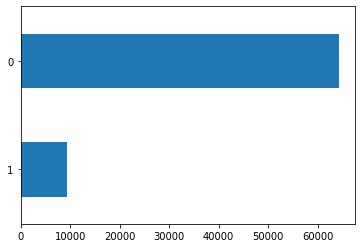

In [127]:
train['default'].value_counts(ascending=True).plot(kind='barh')

In [128]:
train['default'].mean()

0.12699359069906097

Целевые значения в трейне несбалансированы, учтём это во время обучения модели.

# Предобработка признаков

## Client_id

In [129]:
df.client_id.value_counts().sort_values()

2047      1
10235     1
12282     1
14329     1
16376     1
         ..
104627    1
53274     1
57372     1
102450    1
2049      1
Name: client_id, Length: 110148, dtype: int64

Нет повторяющихся id, удаляем признак.

In [130]:
df.drop(['client_id'], axis = 1, inplace = True)

## Бинарные признаки

Посмотрим на количественное распределение признаков в датасете и их влияние на 'default.


sex   IV score: 0.0035



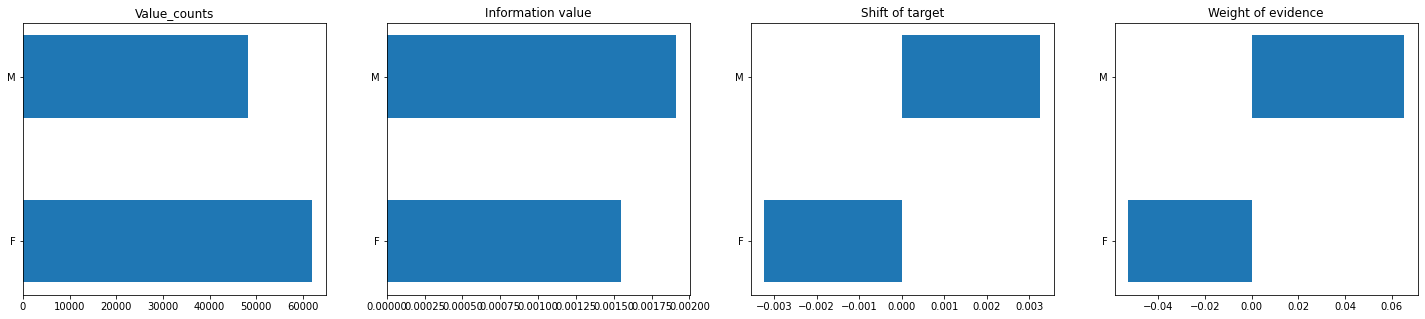



car   IV score: 0.0175



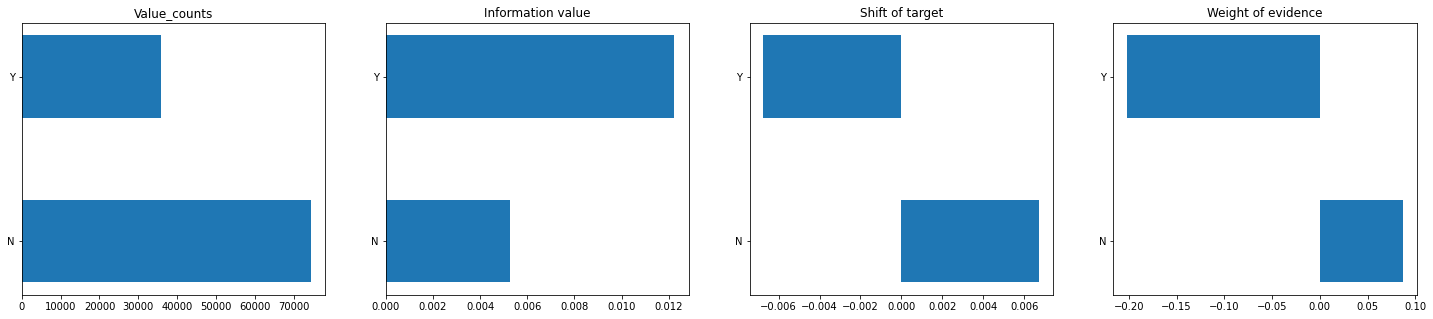



car_type   IV score: 0.0337



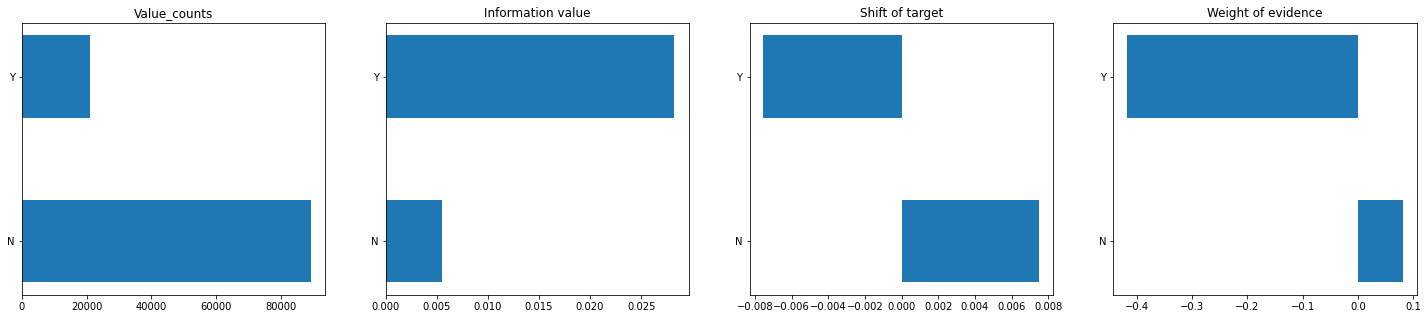



good_work   IV score: 0.0188



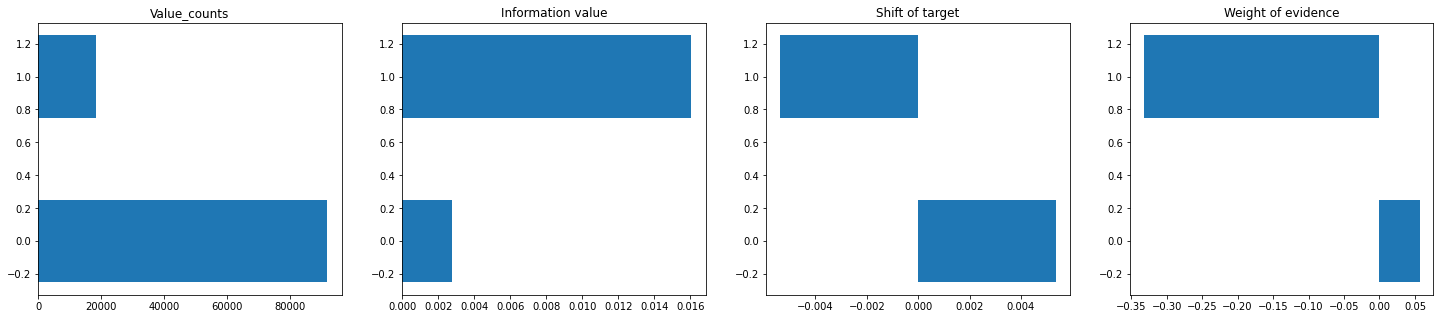



foreign_passport   IV score: 0.0486



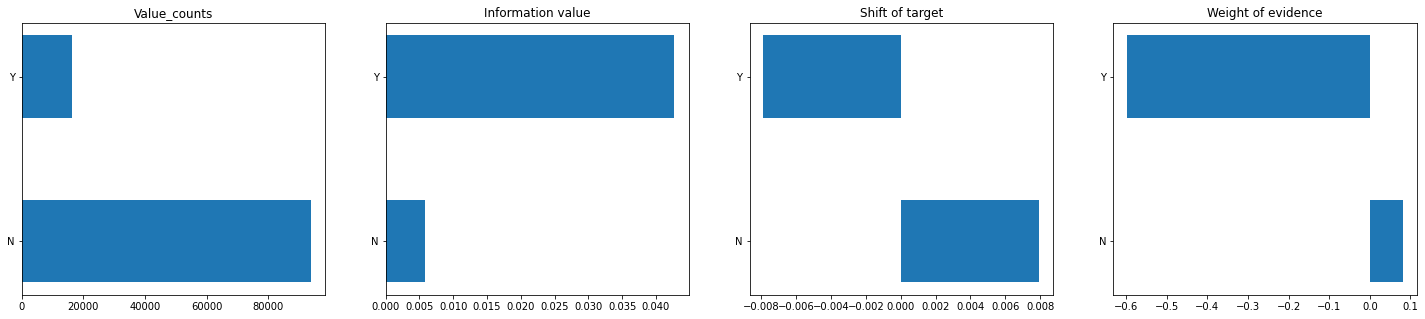

In [131]:
print_barhs(df, bin_cols, 'default')

Заменим значения в признаках на упорядоченные числа в порядке возрастания влияния на дефолт.  
  
Cоздадим категориальный небинарный признак, объединяющий бинарные пересекающиеся признаки car и car_type: car_car_type  
  
car_car_type: 0 - нет автомобиля, 1 - отечественный автомобиль, 2 - иномарка

In [132]:
df = order_values(df, bin_cols, 'default')

df.loc[df['car'] == 1, 'car_car_type'] = 0
df.loc[(df['car'] == 0) & (df['car_type'] == 1), 'car_car_type'] = 1
df.loc[df['car_type'] == 0, 'car_car_type'] = 2

cat_cols.append('car_car_type')

In [133]:
# формируем признаки и data для обучения модели
data = df[bin_cols].astype(float).copy()
bin_features = data.columns.to_list()

В выводах опишем влияние признаков по суммарному значению Information Value и Weight of Evidence

Значимые признаки:
- наличие загранпапспорта снижает вероятность дефолта
- наличие машины снижает вероятность дефолта; наличие иномарки сильнее снижает вероятность дефолта
- хорошая работа снижает вероятность дефолта  

Малозначимые признаки:
- пол

## Категориальные (ординальные) признаки

Мы уже видели небольшое количество пропусков в признаке 'education'. Пометим пропуск.

In [134]:
df['education'].fillna('isNaN', inplace = True)

Посмотрим на количественное распределение признаков в датасете и их влияние на 'default'.


education   IV score: 0.0727



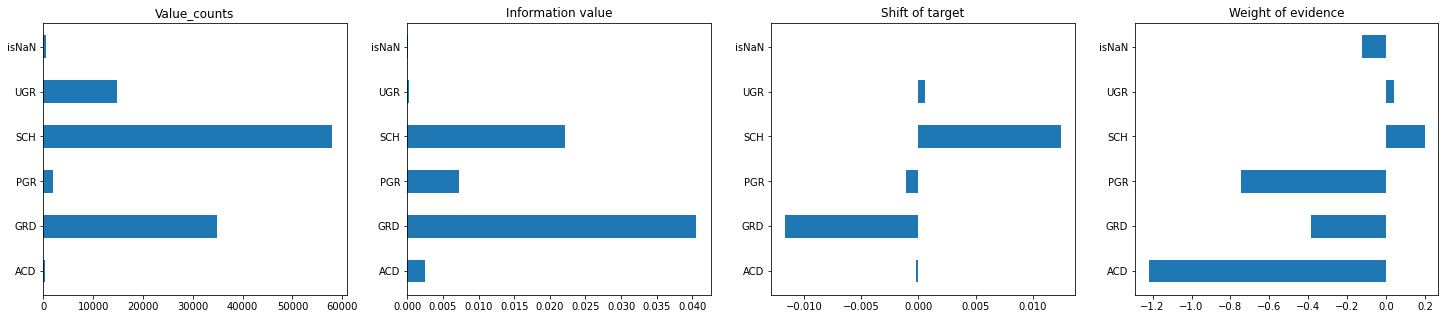



first_time   IV score: 0.1012



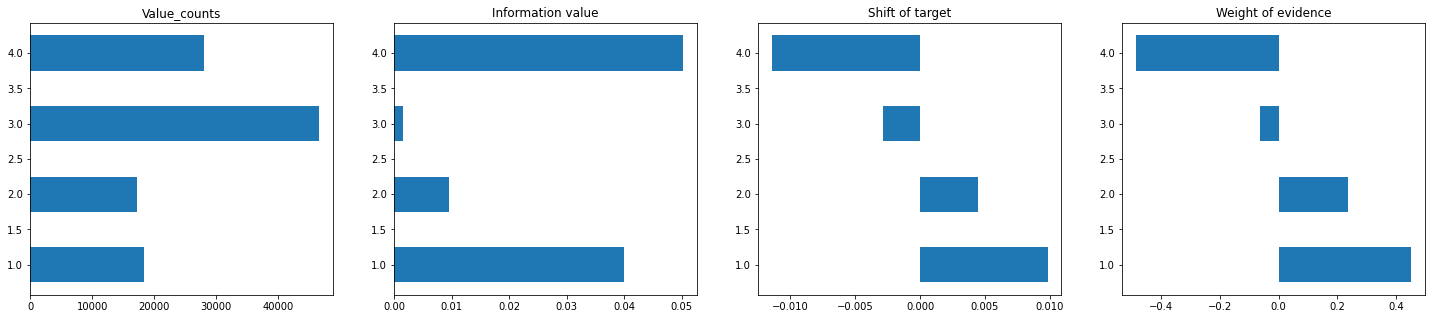



sna   IV score: 0.1320



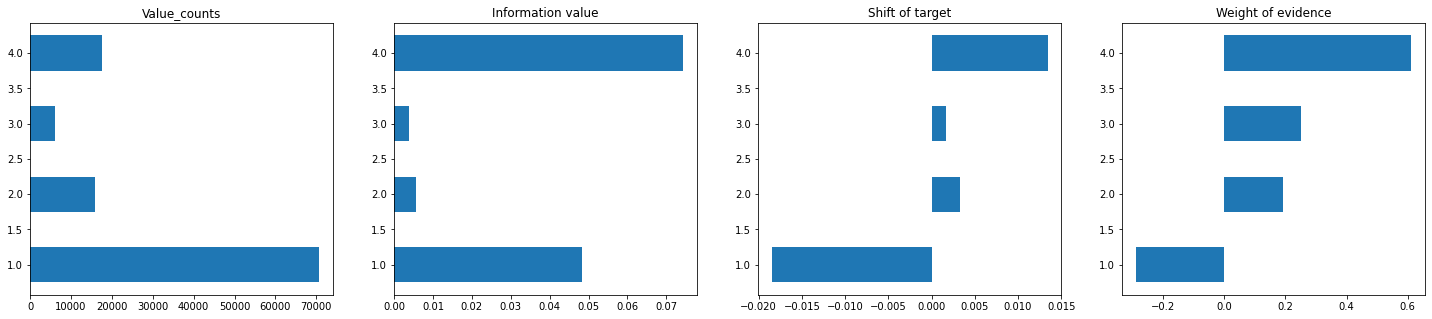



work_address   IV score: 0.0674



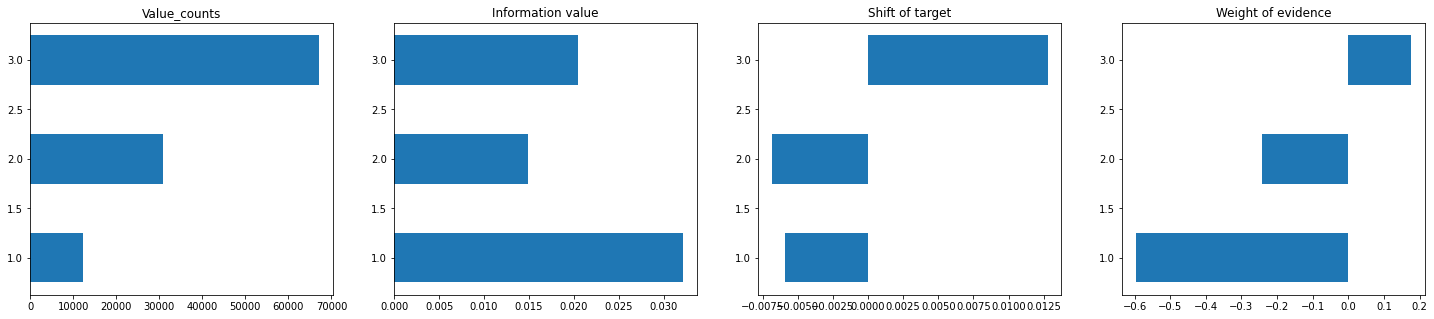



home_address   IV score: 0.0799



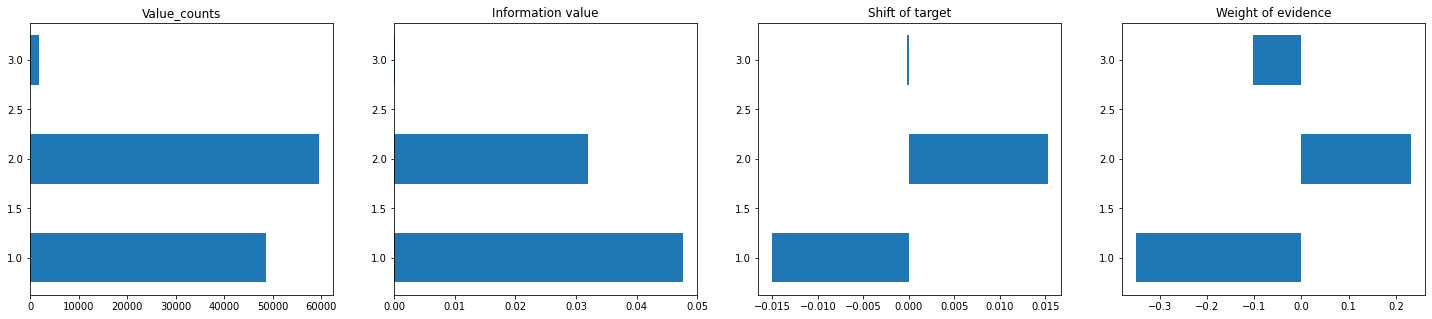



region_rating   IV score: 0.0818



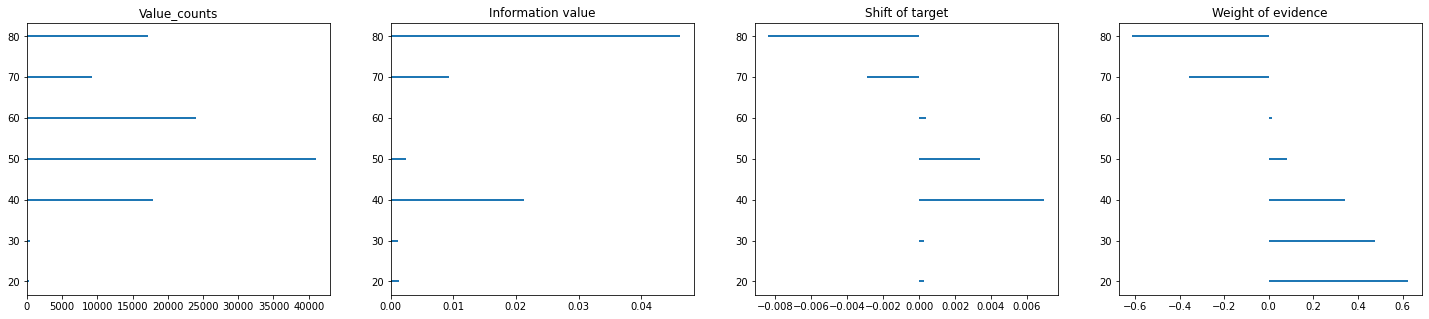



car_car_type   IV score: 0.0339



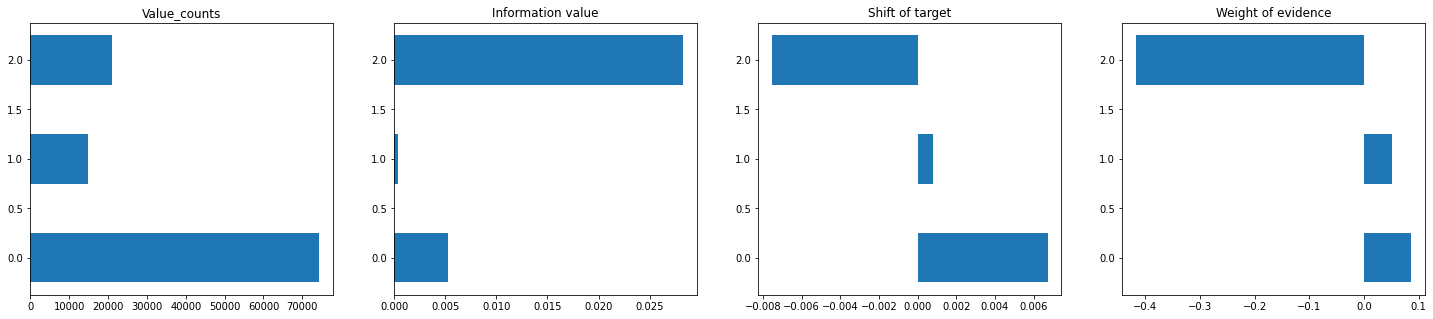

In [135]:
print_barhs (df, cat_cols, 'default')

Все признаки влияют на дефолт.
По графикам пронумеруем значения по влиянию на дефолт:
SCH - 0 
UGR - 1 
GRD - 2 
PGR - 3
ACD - 4  
Отметим отношение значений home_address к дефолту, чтобы сделать из этого признака ординальный признак изменим порядок значения 3 на значение 2 и наоборот.

Упорядочим признаки по WoE. Также видим, что есть значения с очень малым количеством значений. В ручную объединим такие значения с соседними значениями ближайшими по WoE. Посмотрим на то, что получилось.


education   IV score: 0.0722



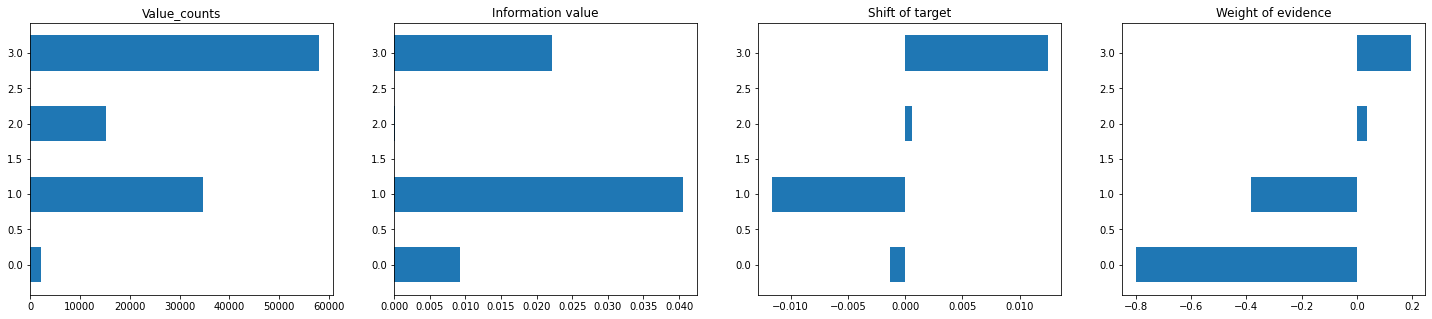



first_time   IV score: 0.1012



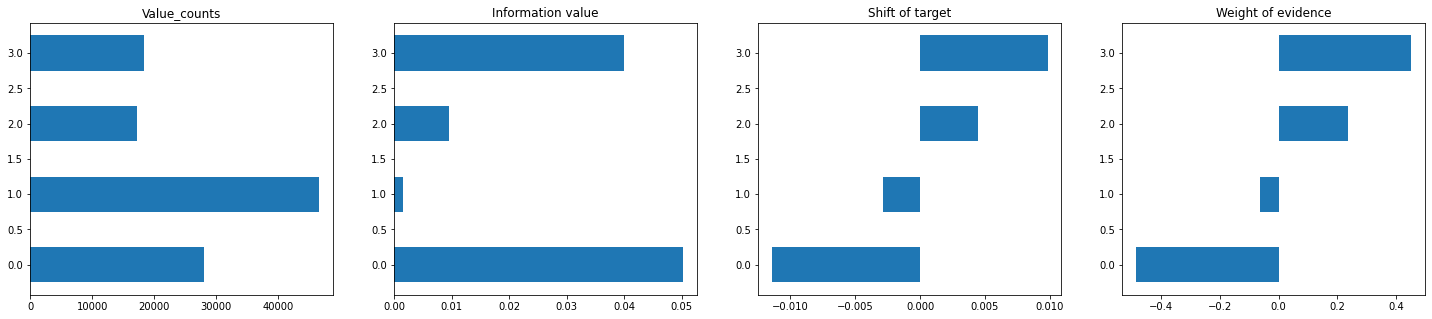



sna   IV score: 0.1320



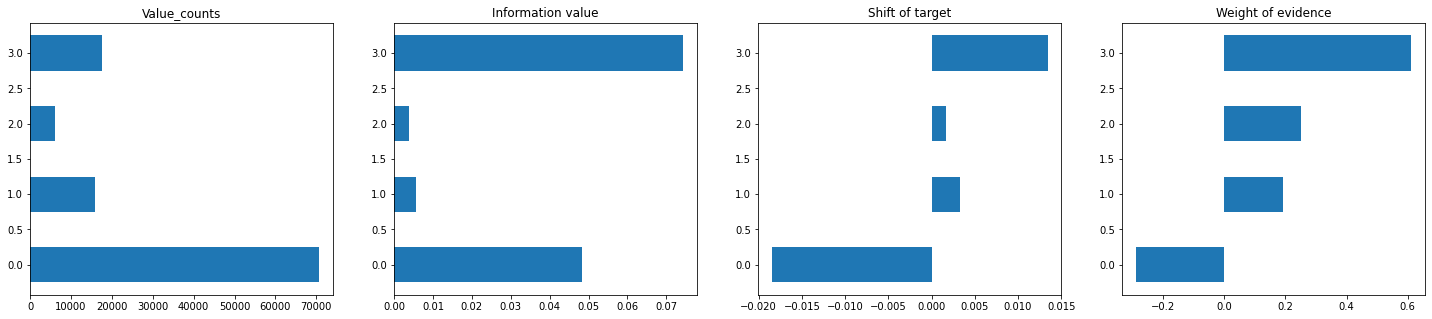



work_address   IV score: 0.0674



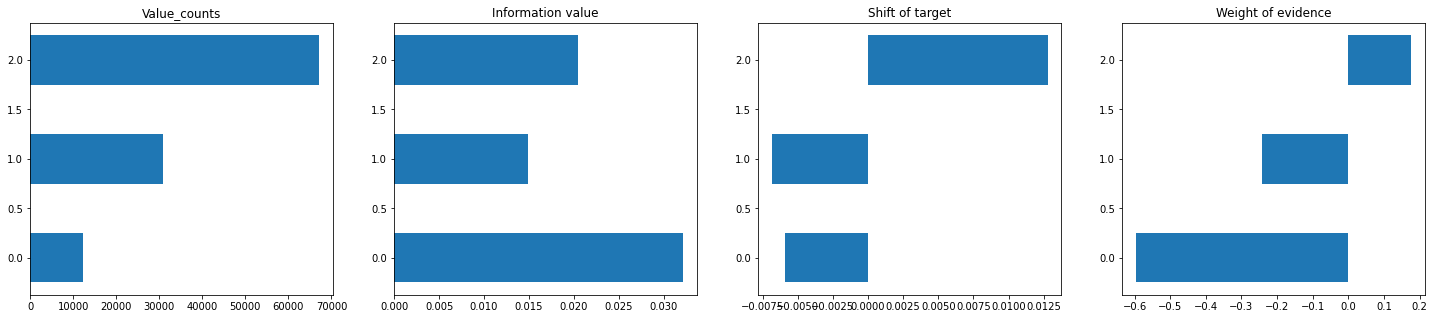



home_address   IV score: 0.0799



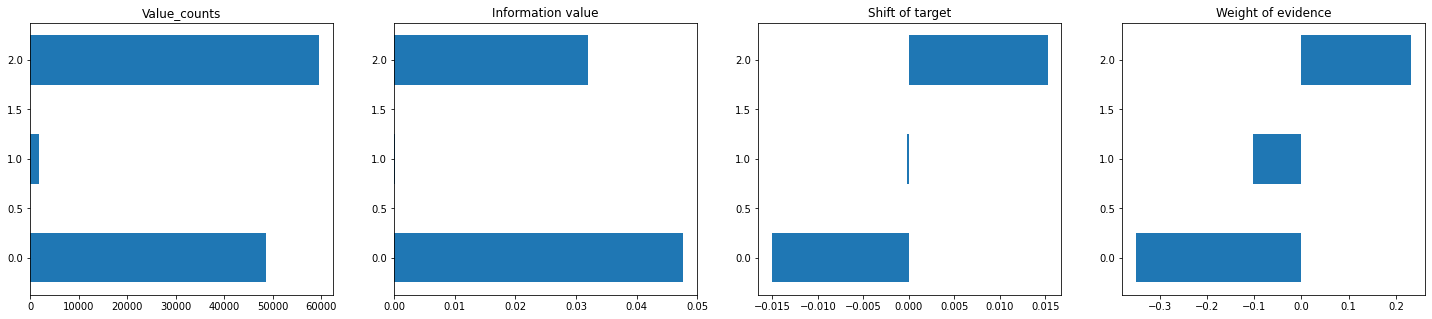



region_rating   IV score: 0.0818



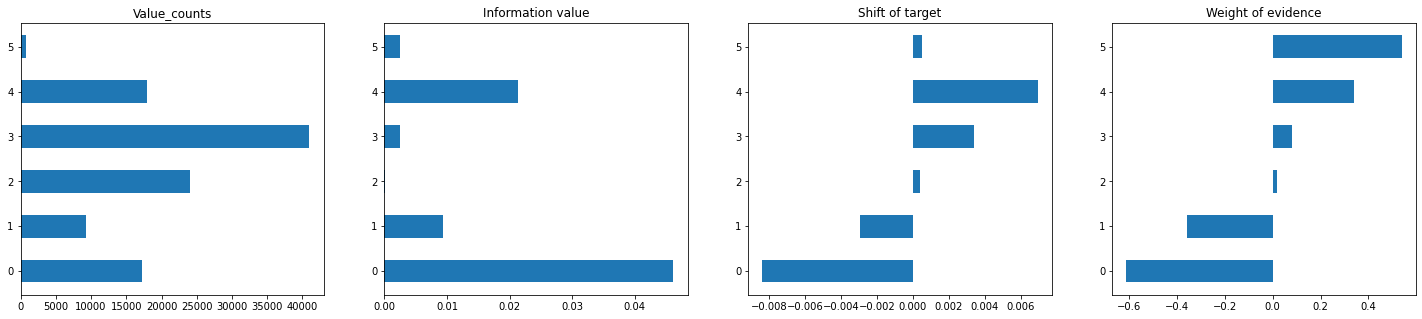



car_car_type   IV score: 0.0339



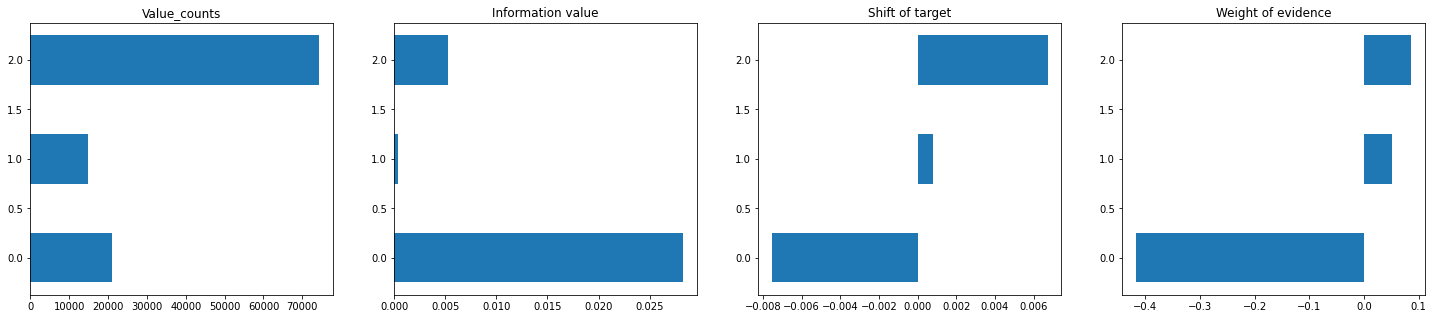

In [136]:
df = order_values(df, cat_cols, 'default')

# сольём с другими значениями пропуски в education и небольшое количество академиков
df.loc[df.education == 3, 'education'] = 4
df.loc[df.education == 0, 'education'] = 1

# объеденим неблагоприятные для дефолта регионы 5 и 6
df.loc[df.region_rating == 6, 'region_rating'] = 5

df = order_values (df, cat_cols, 'default')

print_barhs(df, cat_cols, 'default')

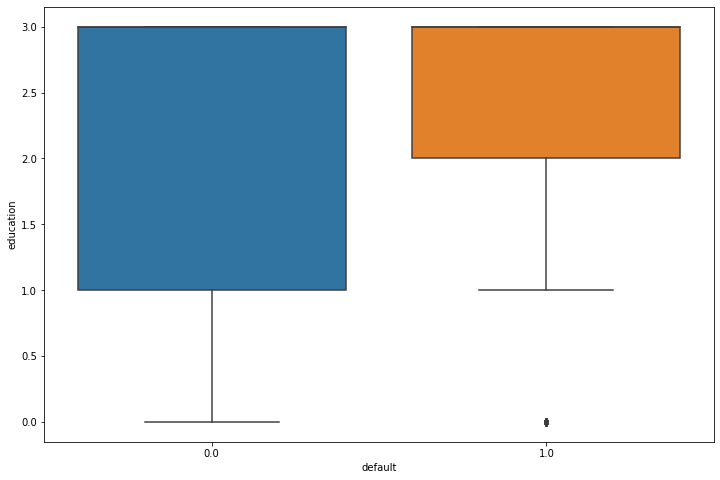

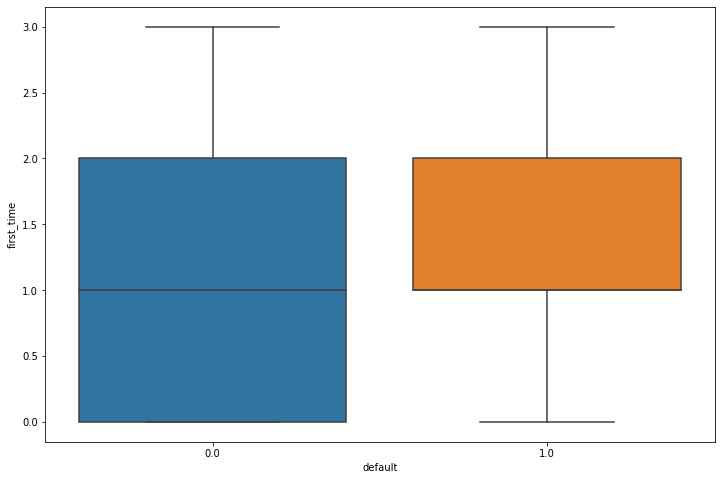

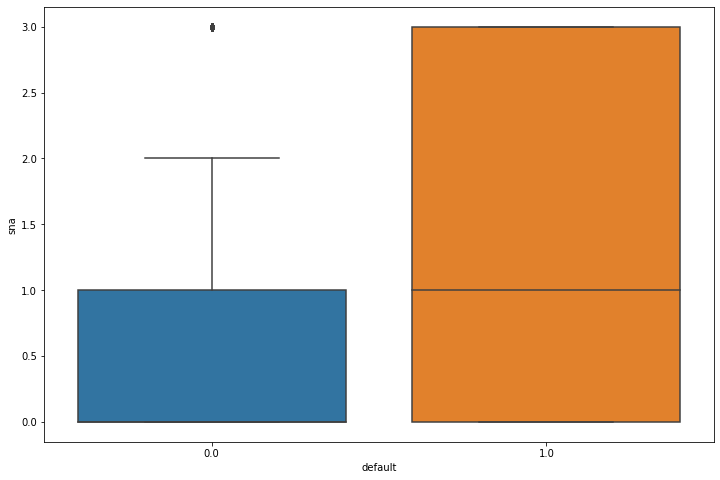

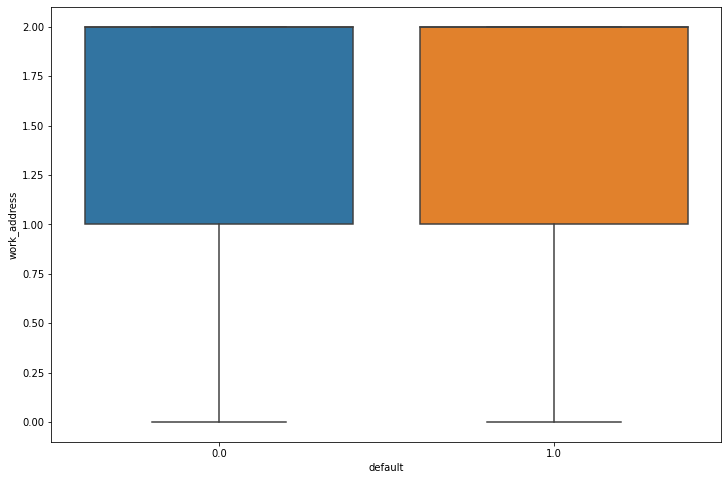

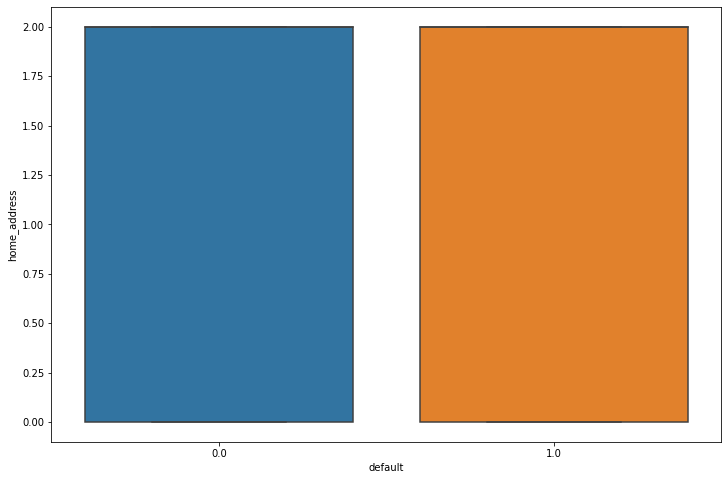

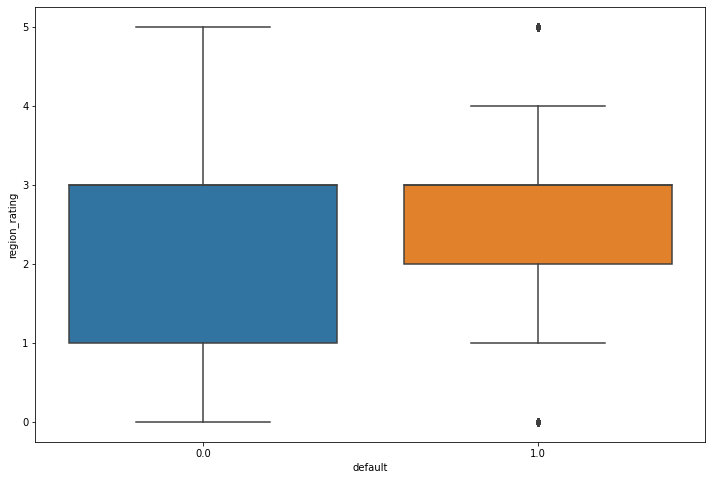

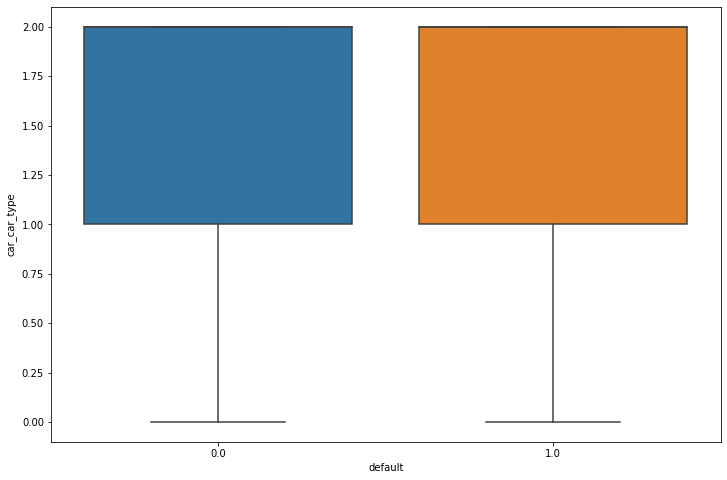

In [137]:
# посмотрим и на боксплоты, чтобы увидеть как влияет номер категориальной переменной на дефолт
boxplots (df, cat_cols, 'default')

In [138]:
# создадим дамми-колонки для категориальных признаков и дополним ими данные для обучения
temp = pd.get_dummies(df[cat_cols], columns = cat_cols)
data = pd.concat([df[cat_cols], temp, data], axis = 1)

bin_features = bin_features + temp.columns.to_list()
cat_features = cat_cols

Сделаем выводы по IV, WoE и Боксплотам.

Значимые признаки:  
- чем больше связей с людьми с просроченной задолженностей, тем выше вероятность дефолта.
- чем больше кредитов было выдано человеку, тем выше вероятность дефолта
- категории домашнего и рабочего адресов
- чем ниже рейтинг региона, тем выше вероятность дефолта.
- чем выше образование, тем меньше вероятность дефолта
- чем выше условный уровень автомобиля (нет, отечественный, иномарка), тем ниже вероятность дефолта

## Численные значения

Посмотрим на распределения признаков.

In [139]:
positive_cols = num_cols.copy()
positive_cols.remove('score_bki')

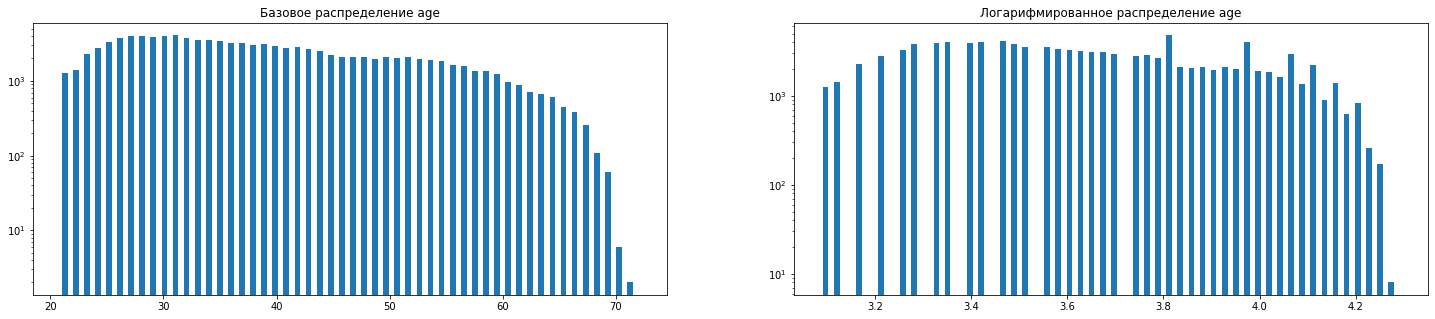

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


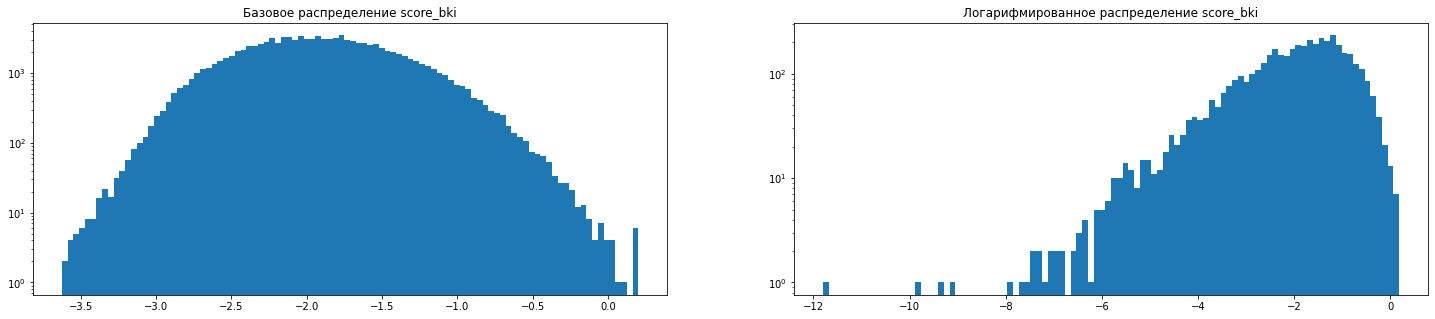

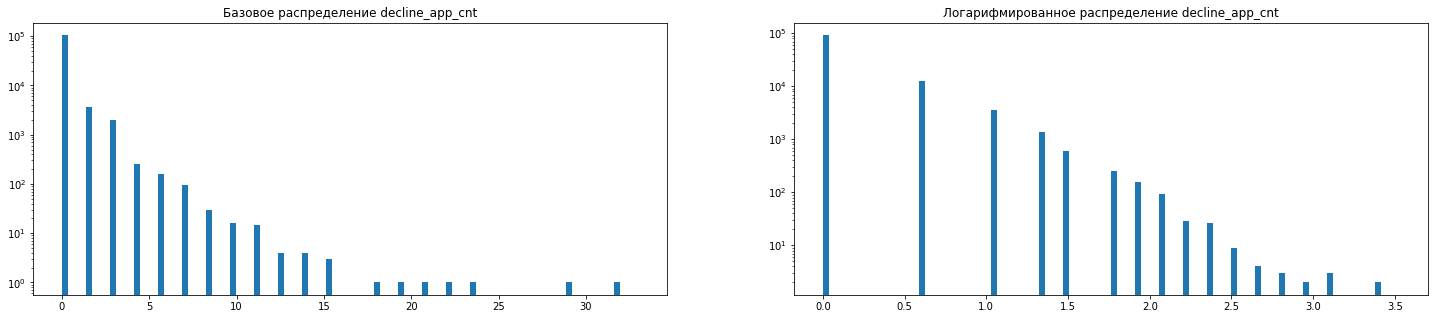

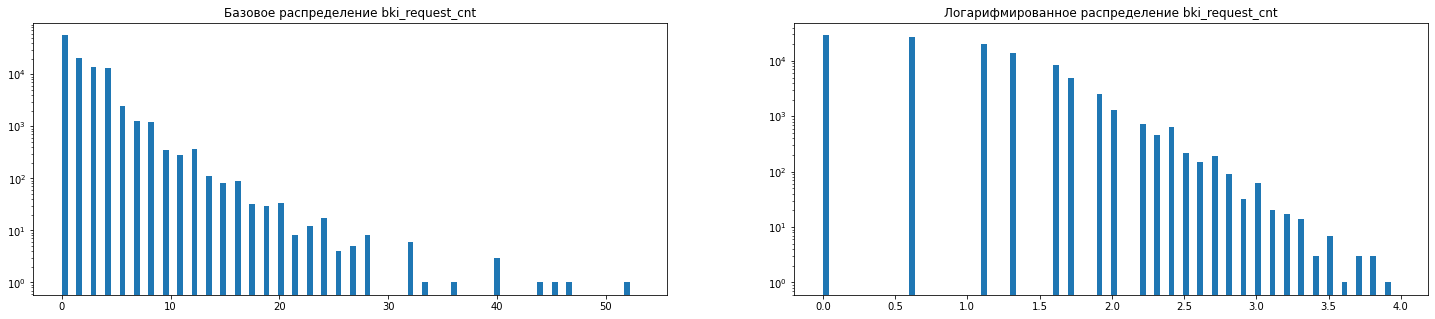

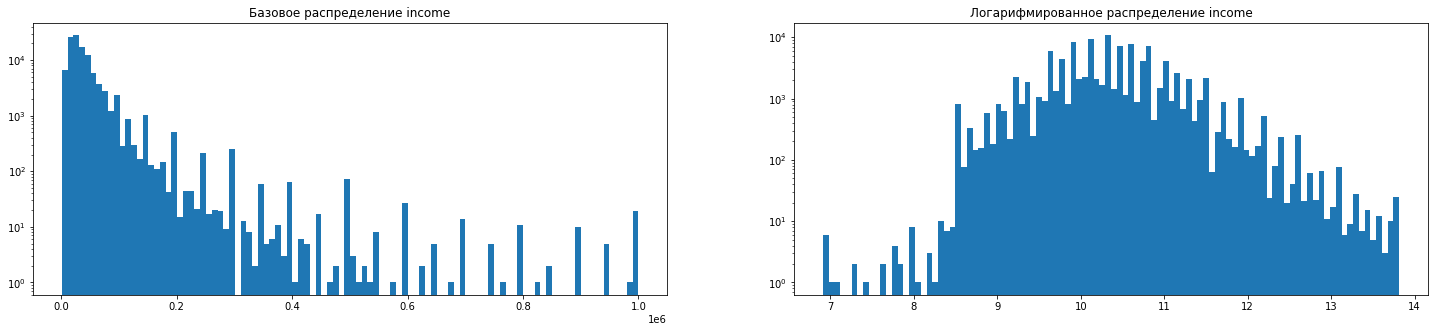

In [140]:
# сравним распределение признаков с логарифмированным распределением (логарфмированная сетка)
hist_log_compare (df, num_cols, 'default')

Видим тяжелые хвосты у некоторых переменных. Прологарифмируем признаки: 'income', 'decline_app_cnt', 'bki_request_cnt', 'age'  

Также отметим необычные распределения в областях максимальных и минимальных значений у Score и Income. В разделе новых признаков рассмотрим эти участки детальнее.

In [141]:
for col in ['income', 'decline_app_cnt', 'bki_request_cnt', 'age']:
    df[col] = np.log(df[col]+1)

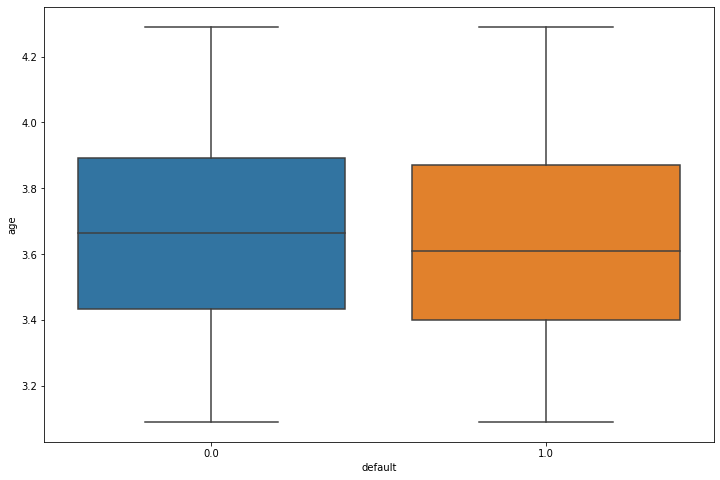

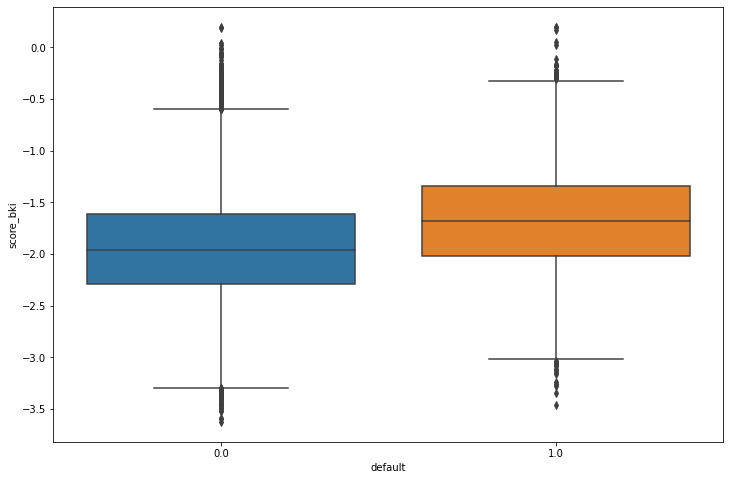

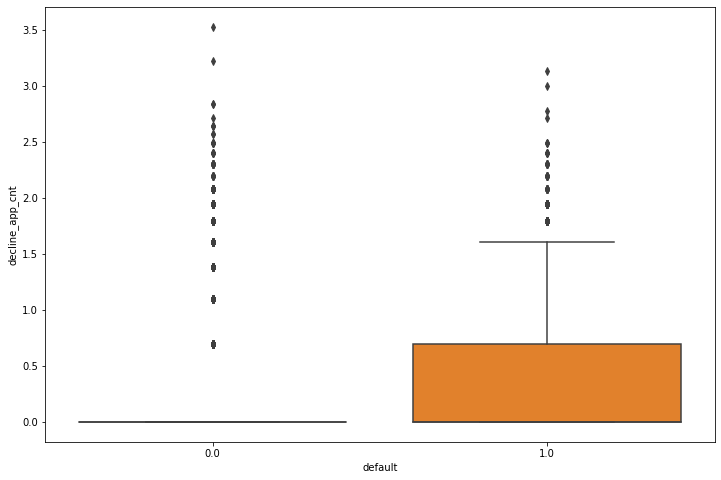

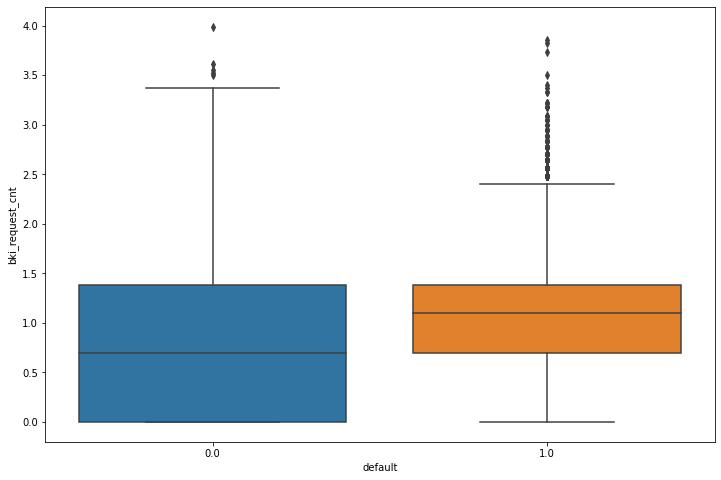

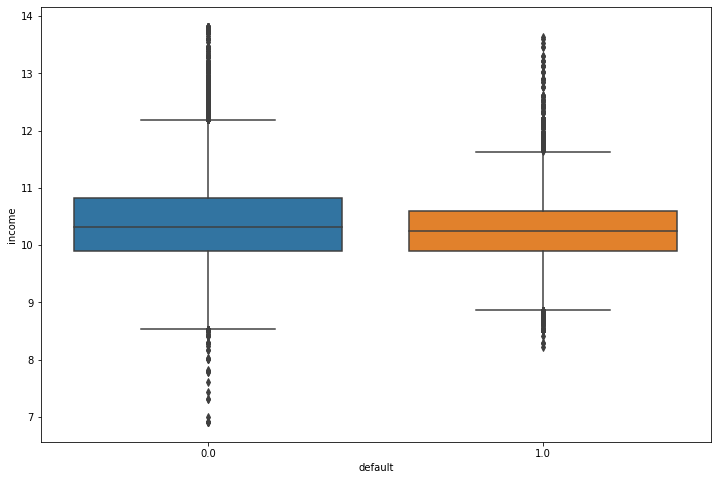

In [142]:
# посмотрим на боксплоты получившихся признаков
boxplots(df, num_cols, 'default')

Возможно, мы видим выбросы в области минимальных значений доходов. В разделе новых признаков посмотрим на эти места детальнее.
Посмотрим на корреляцию признаков с 'default'. Сделаем предварительные выводы.

In [143]:
df[num_cols + ['default']].corr().default.sort_values()

income            -0.053871
age               -0.026119
bki_request_cnt    0.078501
decline_app_cnt    0.124027
score_bki          0.175369
default            1.000000
Name: default, dtype: float64

In [144]:
# продолжим готовить данные для обучения модели
data = pd.concat([df[num_cols], data], axis = 1)
num_features = num_cols

Выводы:  
Значимые признаки:  
- Чем больше запросов от банков по кредитной истории, тем выше вероятность дефолта.  
- Чем больше в прошлом было просроченных задолжностей, тем выше вероятность дефолта.  
- Чем выше оценка заёмщика банком, тем выше вероятность дефолта.  

Малозначимые признаки:
- Чем выше возраст, тем ниже вероятность дефолта.  

Неочевидные признаки:
- Доход

## Даты

Переведём дату в рабочий формат.

In [145]:
df['app_date'].head(3)

0    01FEB2014
1    12MAR2014
2    01FEB2014
Name: app_date, dtype: object

In [146]:
dates = [['JAN','-01-'],
         ['FEB','-02-'],
         ['MAR','-03-'],
         ['APR','-04-'],
         ['MAY','-05-'],
         ['JUN','-06-'],
         ['JUL','-07-'],
         ['AUG','-08-'],
         ['SEP','-09-'],
         ['OCT','-10-'],
         ['NOV','-11-'],
         ['DEC','-12-']]

for date in dates:
    df.loc[df['app_date'].str.contains(date[0], na = False), 'app_date'] = df.loc[df['app_date'].str.contains(date[0], na = False ), 'app_date'].str.replace(date[0],date[1])

df['app_date'] = df['app_date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))

В датах представлен один год - 2014, не будем выделять его. Выделим месяц и день, создадим признак продолжающегося времени с шагом в один день.

In [147]:
df['app_date_month'] = df['app_date'].apply(lambda x: float(x.month))
df['app_date_day'] = df['app_date'].apply(lambda x: float(x.day))
df['date_continious'] = df['app_date_month'] * 30 + df['app_date_day']

In [148]:
date_cols = ['app_date_month', 'date_continious']

Посмотрим на IV, WoE, Боксплоты


app_date_month   IV score: 0.0142



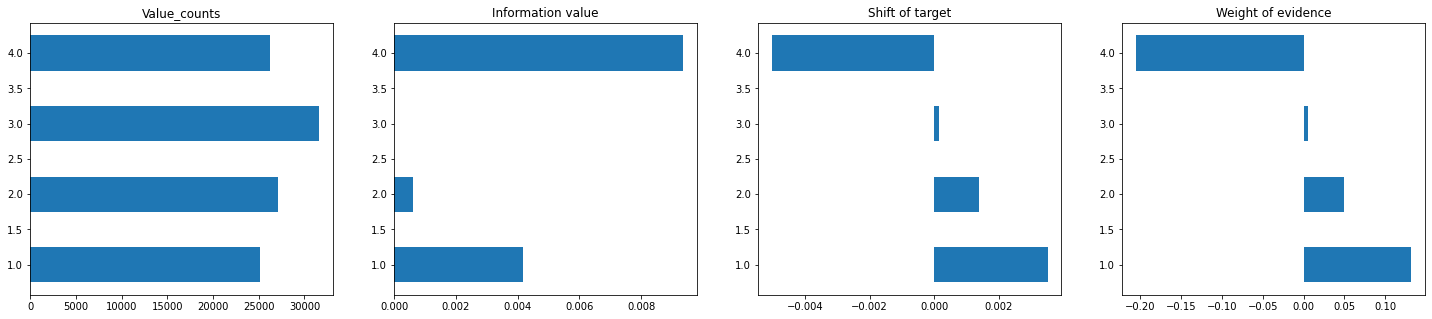

In [149]:
print_barhs(df, ['app_date_month'], 'default')

В датасете представлены месяцы: январь, февраль, март, апрель.

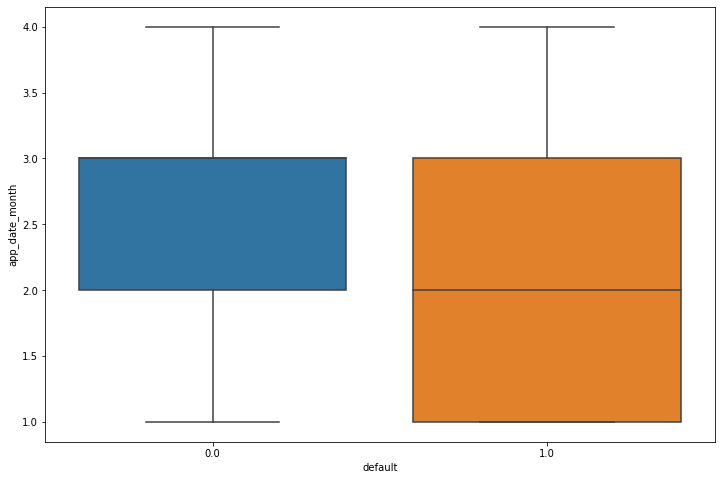

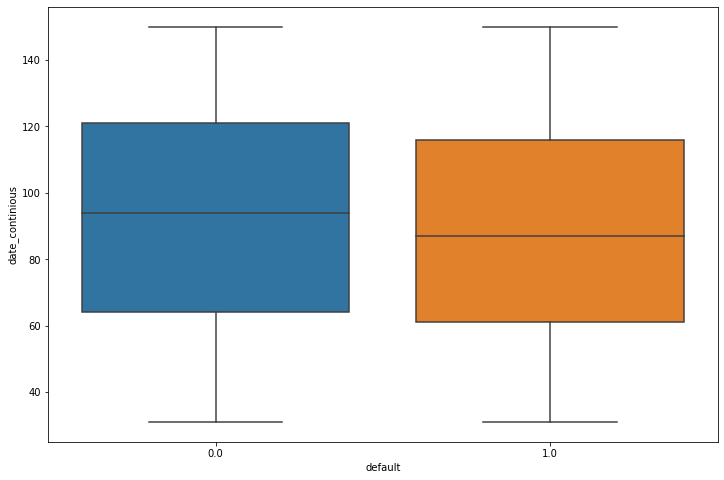

In [150]:
boxplots(df, date_cols, 'default')

In [151]:
temp = pd.get_dummies(df[['app_date_month']], columns = ['app_date_month'])
data = pd.concat([df[date_cols], temp, data], axis = 1)
bin_features = bin_features + temp.columns.to_list()
cat_features = cat_features + ['app_date_month']
num_features = num_features + ['date_continious']

Выводы:  
В начале года риск дефолтов был выше.  
В апреле дефолтов было меньше.

# Базовая модель. Метрики

Создадим таблицу для фиксации изменения метрик. Приоритетная метрика f1.  
Проверим результаты логистической регрессии на подготовленных данных.  
Для скалирования данных будем использовать MinMaxScaler.  
Так как целевая переменная несбалансирована будем передавать параметр class_wight = 'balanced'.  
Каждая метрика равна среднему значению метрики 5-фолдовой кросс валидации.

In [152]:
metrics = pd.DataFrame(index = ['f1', 'precision', 'recall', 'roc_auc'])

In [153]:
features = data.columns.to_list()
data = pd.concat([data, df['default']], axis = 1)

In [154]:
logreg = LogisticRegression(class_weight = 'balanced', solver='liblinear', max_iter=1000)
metrics = check_metrics (data, features, test, 'default', MinMaxScaler(), logreg, metrics, 'baseline')
metrics

,baseline
f1,0.3410
precision,0.2287
recall,0.6698
roc_auc,0.7351


# Новые признаки. Метрики

Постараемся учесть особенности признаков и сгенерировать новые признаки, чтобы улучшить значение метрик.  
  
Разобъем числовые признаки на корзины с минимальным количеством значений по 0.5% в каждой, чтобы посмотреть на возможные аномалии и выбросы на концах распределения признаков.

In [155]:
data, num_cols_bins005 = col_by_bins(data, num_cols, 0.005)


age_bins0.005   IV score: 0.0117



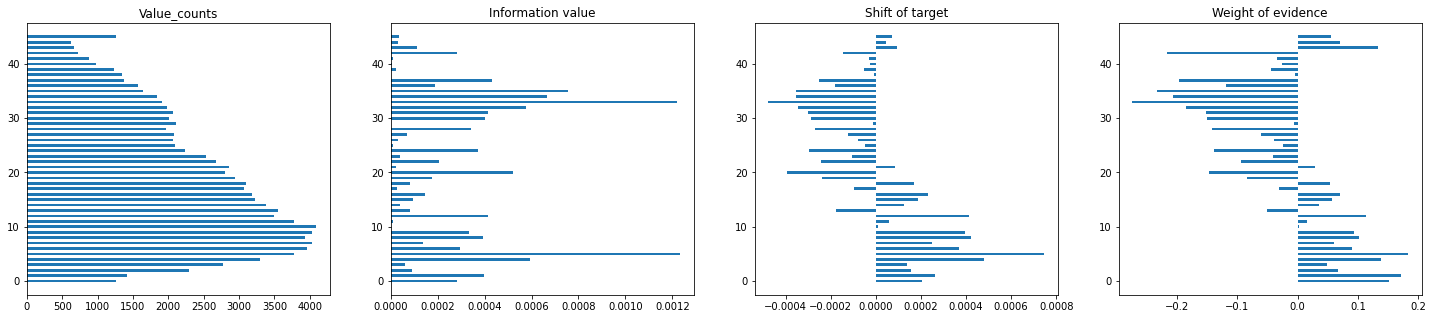



score_bki_bins0.005   IV score: 0.3147



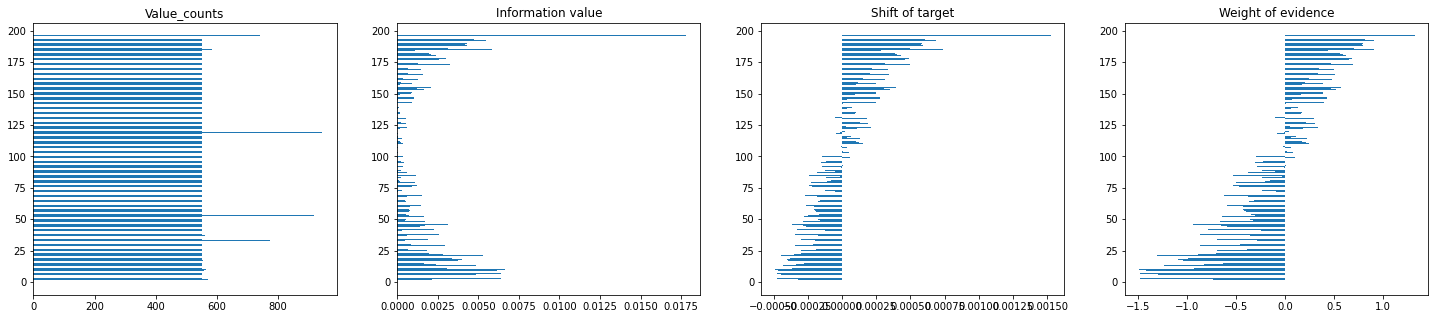



decline_app_cnt_bins0.005   IV score: 0.1121



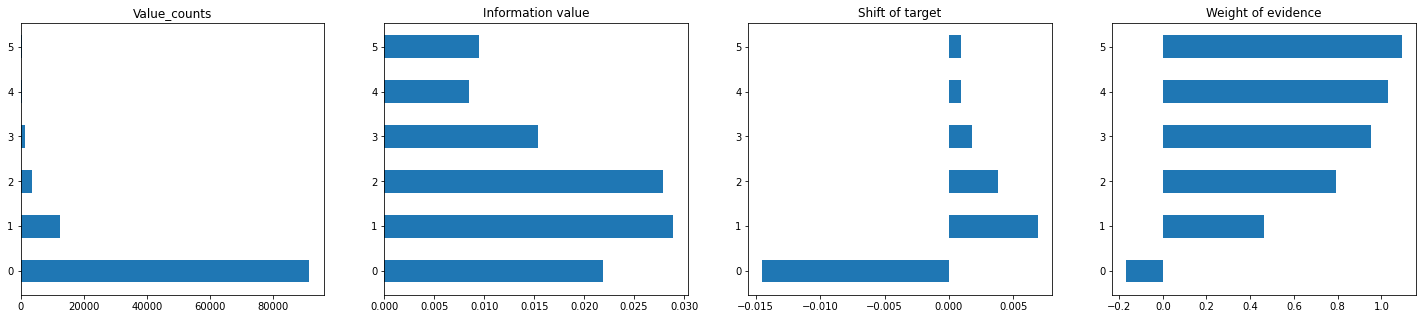



bki_request_cnt_bins0.005   IV score: 0.0562



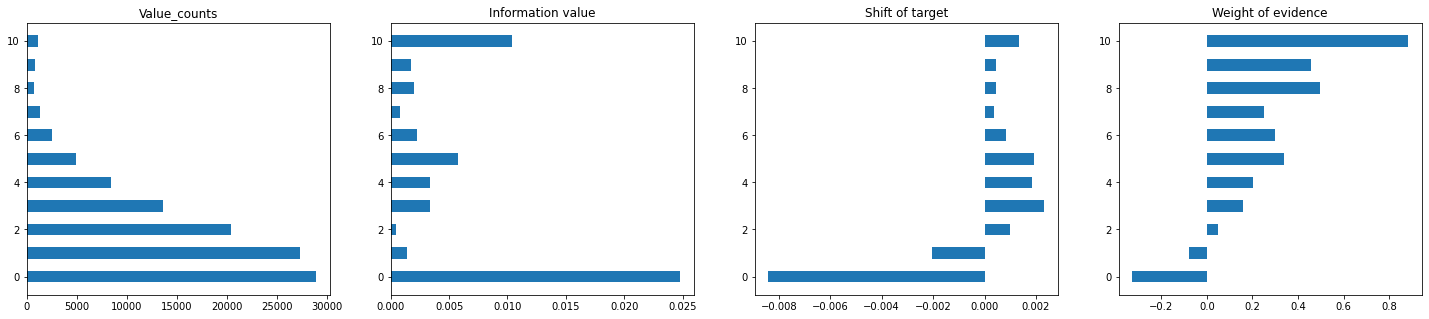



income_bins0.005   IV score: 0.0489



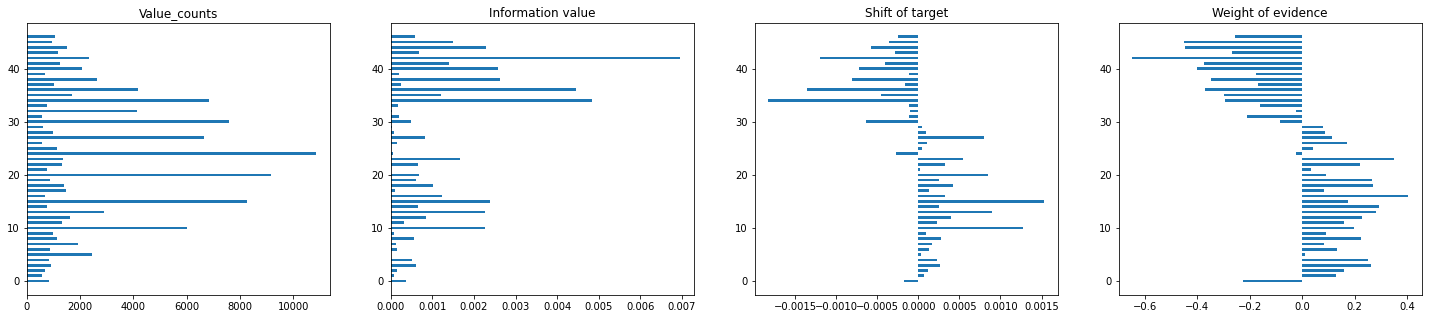

In [156]:
print_barhs(data, num_cols_bins005, 'default')

Выделим необычные или важные участки числовых данных в дамми-признаки:

1. Изменение направления WoE:  
Первая корзина Income, корзины 30 и более Income, корзины 1-29 Income, три последние корзины Age.
  
  
2. Небычный WoE в сравнении с соседними:  
Первая корзина score_bki  
  
3. Большая важность корзины в сравнении с другими корзинами:  
Первые корзины bki_request, decline. Последняя корзина bki_request. Последняя корзина score_bki. 42-я корзина Income. 

Выделяя минимальные и максимальные значения мы пометили и места возможных выбросов, поэтому дополнительную обработку выбросов делать не будем, каких-то серьёзных аномалий я не увидел.

In [157]:
data['age_old'] = 0
data.loc[data['age_bins0.005'].isin(np.unique(data['age_bins0.005'])[-3:]), 'age_old'] = 1

In [158]:
data['income_up'] = 0
data.loc[data['income_bins0.005'].isin(range(30, 47)), 'income_up'] = 1

In [159]:
data['income_down'] = 0
data.loc[data['income_bins0.005'].isin(range(1, 30)), 'income_down'] = 1

In [160]:
save_bin_features = ['decline_app_cnt_bins0.005_0.0', 'bki_request_cnt_bins0.005_0.0', 'bki_request_cnt_bins0.005_10.0', 
                     'score_bki_bins0.005_196.0', 'score_bki_bins0.005_0.0', 'income_bins0.005_42.0', 
                     'age_old', 'income_up', 'income_down', 'income_bins0.005_0.0']

In [161]:
temp = pd.get_dummies(data[num_cols_bins005], columns = num_cols_bins005)
data = pd.concat([data, temp], axis = 1)
bin_features = bin_features + save_bin_features

Дополнительно разделим численные признаки  на корзины с минимальным количеством значений по 5% в каждой, т.к. мы могли не заметить какой-то особенности распределения значений. Сделаем из них дамми переменные и добавим в наши признаки для обучения.

In [162]:
data, num_cols_bins05= col_by_bins(data, num_cols, 0.05)


age_bins0.05   IV score: 0.0091



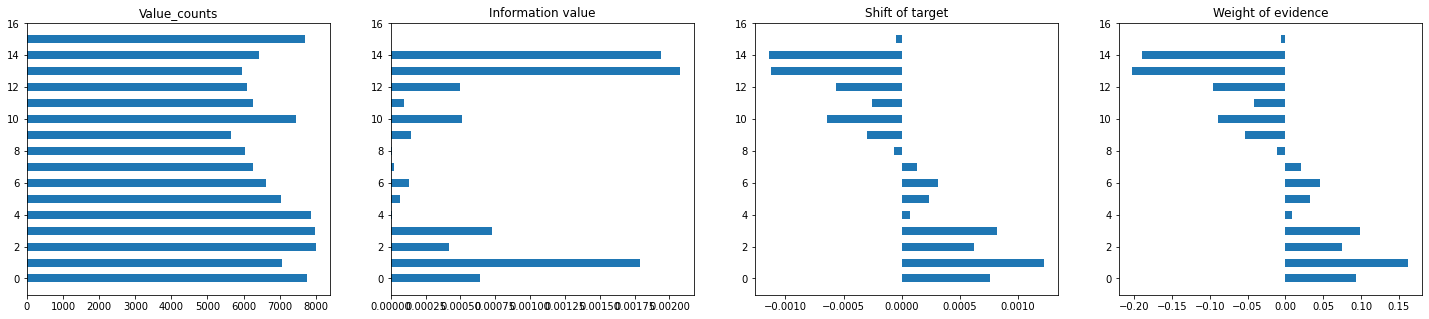



score_bki_bins0.05   IV score: 0.2818



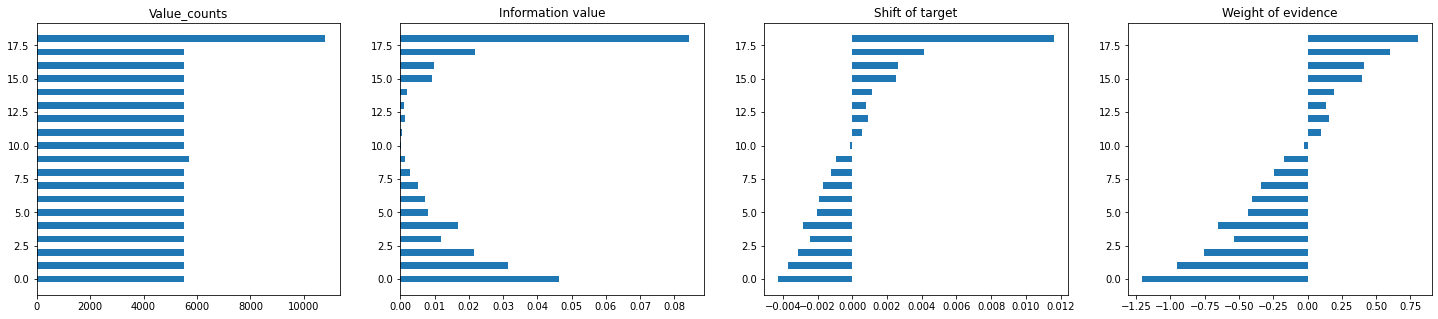



decline_app_cnt_bins0.05   IV score: 0.1111



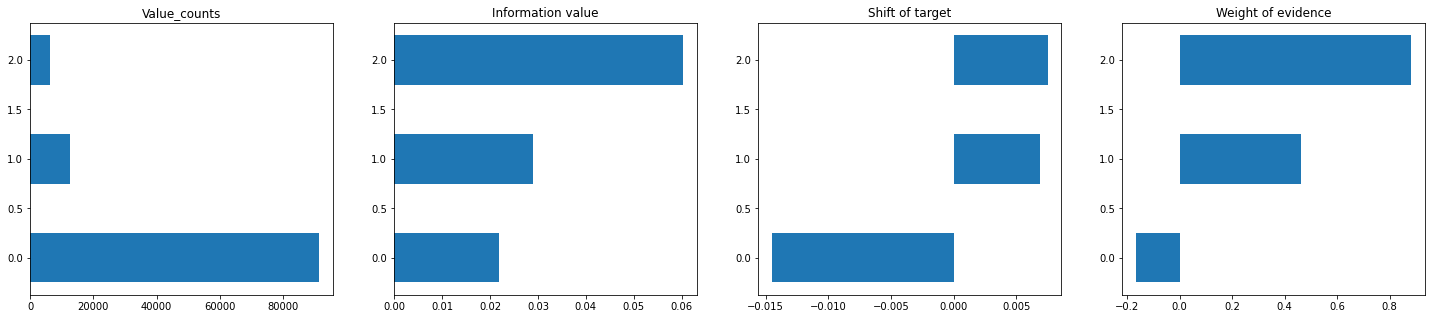



bki_request_cnt_bins0.05   IV score: 0.0522



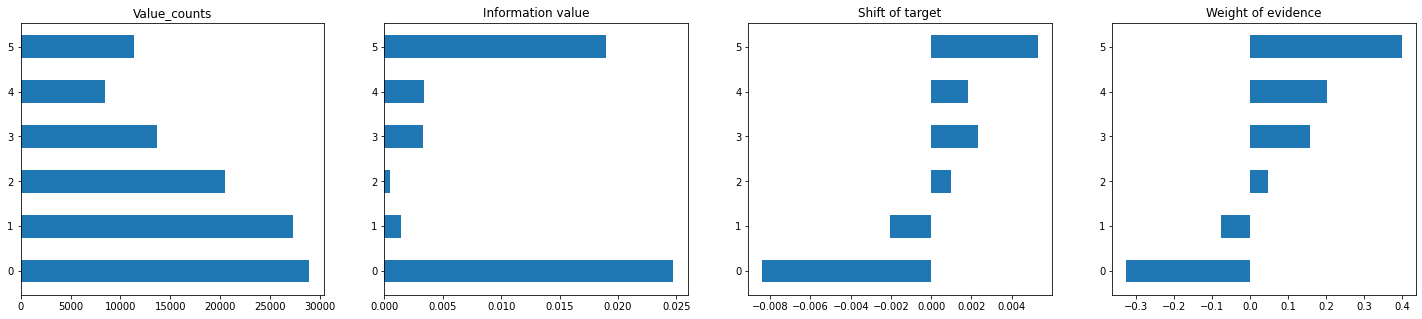



income_bins0.05   IV score: 0.0414



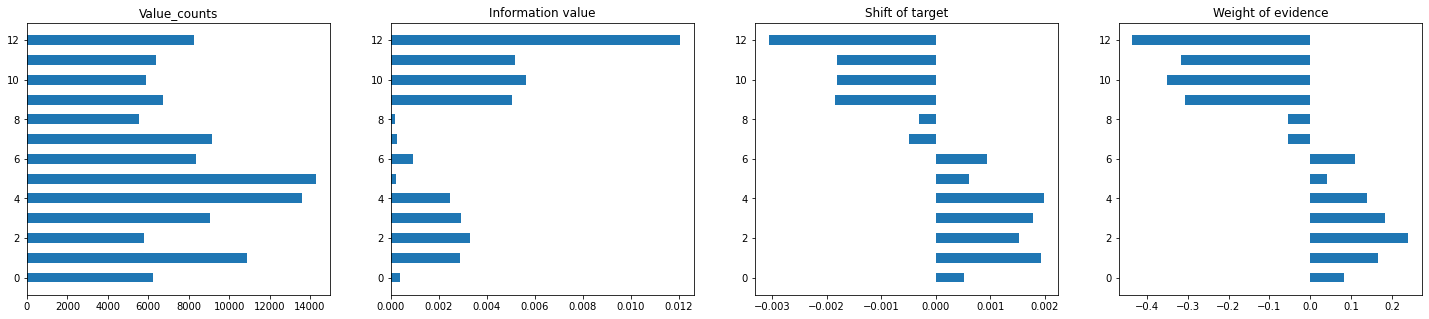

In [163]:
print_barhs(data, num_cols_bins05, 'default')

In [164]:
temp = pd.get_dummies(data[num_cols_bins05], columns = num_cols_bins05)
data = pd.concat([data, temp], axis = 1)
bin_features = bin_features + temp.columns.to_list()

In [165]:
logreg = LogisticRegression(class_weight = 'balanced', solver='liblinear', max_iter=1000)
metrics = check_metrics (data, cat_features + num_features + bin_features, test, 'default', MinMaxScaler(), logreg, metrics, 'new_features')
metrics

,baseline,new_features
f1,0.3410,0.3425
precision,0.2287,0.2296
recall,0.6698,0.6742
roc_auc,0.7351,0.7350


Видим улучшение метрик и precision и recall, как следствие улучшилась и метрика f1

# Отбор признаков. Метрики

## Отбор числовых и подярковых категориальных признаков. Метрики

Посмотрим на важность числовых и категориальных порядковых признаков и их максимальную корреляцию между собой и корреляцию с целевой переменной. Для начала отсортируем таблицу по корреляции.

In [166]:
feature_select = num_ord_features_importants (data, num_features+cat_features, 'default')
feature_select.sort_values(by = ['feat_max_corr','target_corr'], ascending = False).head(20)

,importance,target_corr,feat_max_corr,feat_name
app_date_month,101.797739,-0.037115,0.965055,date_continious
date_continious,113.470379,-0.039182,0.965055,app_date_month
home_address,633.378925,0.092248,0.748340,work_address
work_address,494.460260,0.081582,0.748340,home_address
sna,1187.281038,0.125832,0.525206,first_time
first_time,831.876810,0.105579,0.525206,sna
score_bki,2341.599450,0.175369,0.210090,decline_app_cnt
decline_app_cnt,1152.937317,0.124027,0.210090,score_bki
education,535.060450,0.084842,0.173884,car_car_type
car_car_type,214.943964,0.053890,0.173884,education


Удалим признак app_datr_month, он сильно коррелирует с date_continious.

In [167]:
cat_features.remove('app_date_month')

Посмиотрим на условное влияние на дефолт комбинации значений 'home_address' и 'work_address'

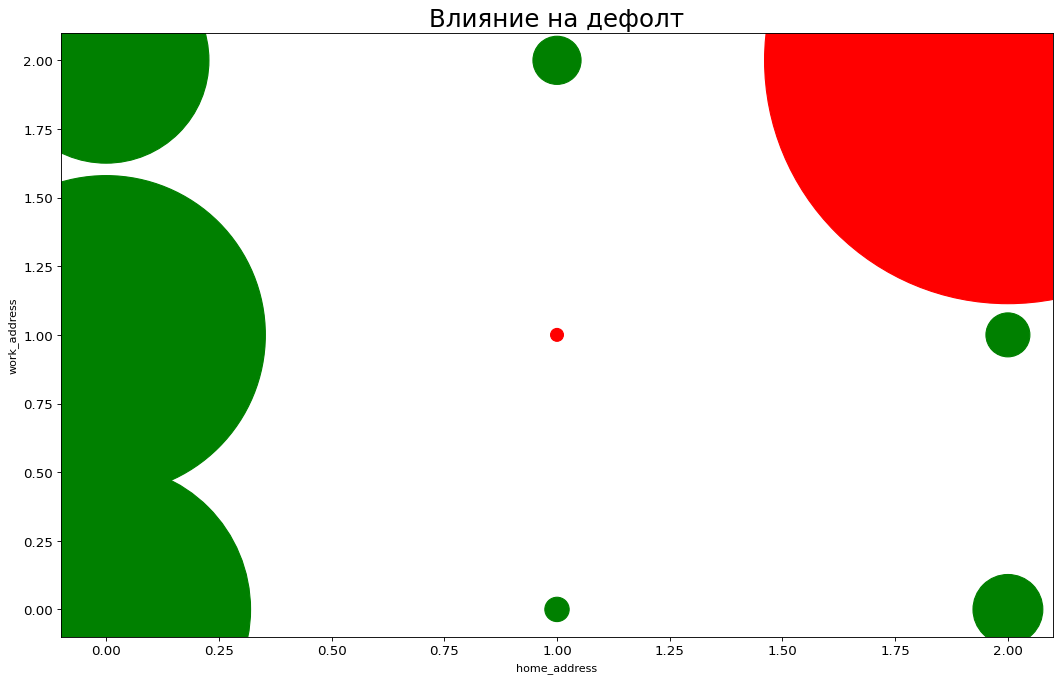

In [168]:
pair_feats_value ('home_address', 'work_address', 'default', data)

Видим, что одновременное максимальное значение обоих признаков сильнее всего негативно влияет на дефолт. Попробуем просто сложить эти два признака, упорядочим по влиянию на дефолт и оценим результат.

In [169]:
data['home_work'] = data['work_address'] + data['home_address']

In [170]:
cat_features = cat_features + ['home_work']

In [171]:
data = order_values (data, ['home_work'], 'default')


home_work   IV score: 0.0919



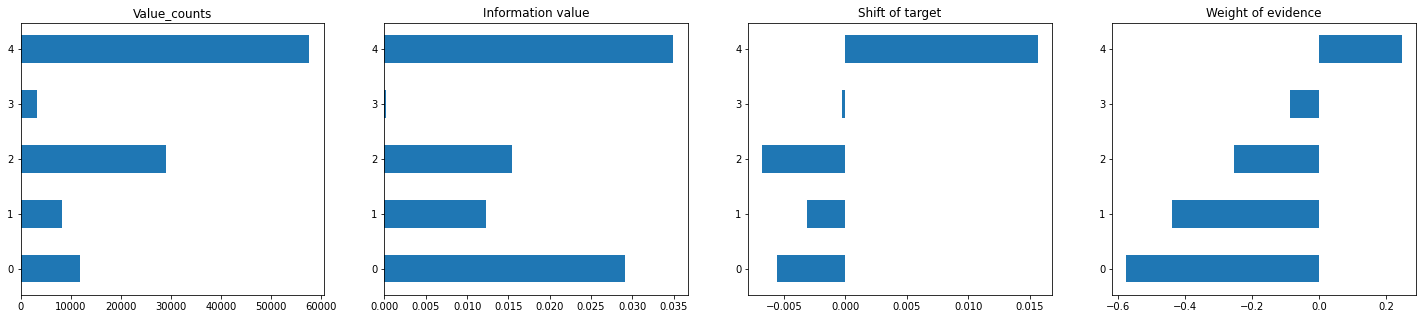



home_address   IV score: 0.0799



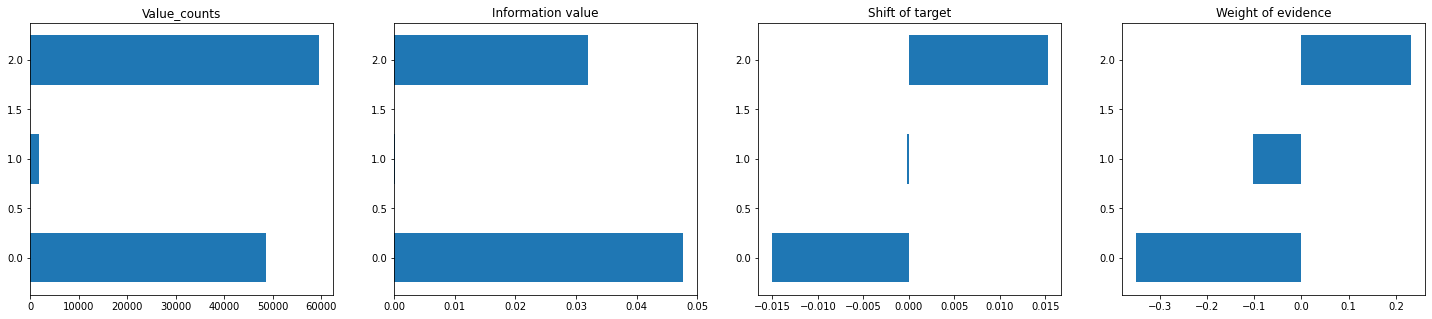



work_address   IV score: 0.0674



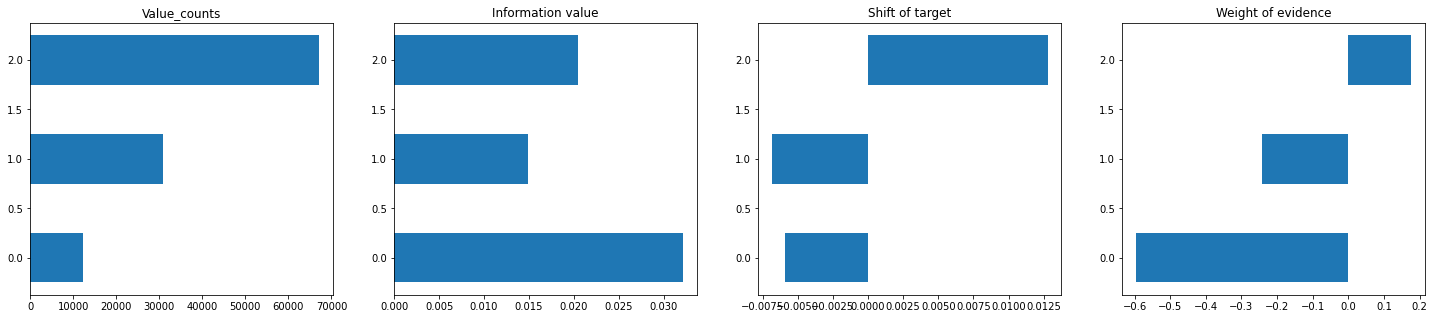

In [172]:
print_barhs(data, ['home_work', 'home_address', 'work_address'], 'default')

In [173]:
feature_select = num_ord_features_importants (data, num_features + cat_features, 'default')
feature_select.sort_values(by = ['feat_max_corr','target_corr'], ascending = False).head(20)

,importance,target_corr,feat_max_corr,feat_name
home_work,685.720828,0.095950,0.903906,home_address
home_address,633.378925,0.092248,0.903906,home_work
work_address,494.460260,0.081582,0.841794,home_work
sna,1187.281038,0.125832,0.525206,first_time
first_time,831.876810,0.105579,0.525206,sna
score_bki,2341.599450,0.175369,0.210090,decline_app_cnt
decline_app_cnt,1152.937317,0.124027,0.210090,score_bki
date_continious,113.470379,-0.039182,0.186730,home_address
education,535.060450,0.084842,0.173884,car_car_type
car_car_type,214.943964,0.053890,0.173884,education


У нового признака home_work выше корреляция с целевой переменной и выше IV. Поэтому мы его оставим и удалим сильноскоррелированные признаки home_address и work_address.  
Дополнительно из признака home_work сгенерируем дамми - признаки.

In [174]:
cat_features.remove('work_address')
cat_features.remove('home_address')

In [175]:
temp = pd.get_dummies(data[['home_work']], columns = ['home_work'])
data = pd.concat([data, temp], axis = 1)
bin_features = bin_features + temp.columns.to_list()

In [176]:
feature_select = num_ord_features_importants (data, num_features + cat_features, 'default')
feature_select

,importance,target_corr,feat_max_corr,feat_name
score_bki,2341.599450,0.175369,0.210090,decline_app_cnt
sna,1187.281038,0.125832,0.525206,first_time
decline_app_cnt,1152.937317,0.124027,0.210090,score_bki
first_time,831.876810,0.105579,0.525206,sna
home_work,685.720828,0.095950,0.174325,date_continious
region_rating,588.443261,0.088942,0.125298,education
education,535.060450,0.084842,0.173884,car_car_type
bki_request_cnt,457.591760,0.078501,0.139622,score_bki
car_car_type,214.943964,0.053890,0.173884,education
income,214.790527,-0.053871,0.081019,bki_request_cnt


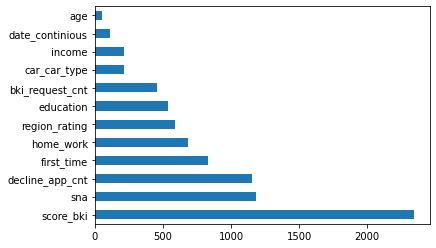

In [177]:
# посмотрим на важность признаков
feature_select['importance'].plot(kind = 'barh')

In [178]:
logreg = LogisticRegression(class_weight = 'balanced', solver='liblinear', max_iter=1000)
metrics = check_metrics (data, cat_features + num_features + bin_features, test, 'default', MinMaxScaler(), logreg, metrics, 'feat_imp_1')
metrics

,baseline,new_features,feat_imp_1
f1,0.3410,0.3425,0.3431
precision,0.2287,0.2296,0.2301
recall,0.6698,0.6742,0.6745
roc_auc,0.7351,0.7350,0.7357


Модель стала эффективней.

## Отбор бинарных признаков. Метрики

Посмотрим на важность и корреляции бинарных признаков.

In [179]:
feature_select = cat_features_importants (data, bin_features, 'default')
feature_select.sort_values(by = ['feat_max_corr', 'importance','target_corr'], ascending = False).head(20)

,importance,target_corr,feat_max_corr,feat_name
decline_app_cnt_bins0.005_0.0,0.010211,-0.115648,1.000000,decline_app_cnt_bins0.05_0.0
decline_app_cnt_bins0.05_0.0,0.010211,-0.115648,1.000000,decline_app_cnt_bins0.05_0.0
bki_request_cnt_bins0.005_0.0,0.005070,-0.057361,1.000000,bki_request_cnt_bins0.005_0.0
bki_request_cnt_bins0.05_0.0,0.005070,-0.057361,1.000000,bki_request_cnt_bins0.005_0.0
car_car_type_2.0,0.003843,0.043161,1.000000,car_car_type_2.0
car,0.003843,0.043161,1.000000,car_car_type_2.0
work_address_0.0,0.003892,-0.056622,0.979595,home_work_0.0
home_work_0.0,0.003623,-0.053997,0.979595,work_address_0.0
home_work_4.0,0.010110,0.094374,0.964762,home_address_2.0
home_address_2.0,0.009775,0.091869,0.964762,home_work_4.0


Удалим очевидные дубли и некоторые сильноскоррелированные признаки. Удалять будем тот признак, который меньше по модулю скоррелирован с целевой переменной.

In [180]:
cols_to_drop =['car', 'home_work_0.0', 'home_address_2.0', 'work_address_1.0', 'work_address_2.0', 'decline_app_cnt_bins0.05_0.0', 'bki_request_cnt_bins0.05_0.0']
for col in cols_to_drop:
        bin_features.remove(col)

In [181]:
feature_select = cat_features_importants (data, bin_features, 'default')
feature_select.sort_values(by = ['feat_max_corr', 'importance','target_corr'], ascending = False).head(20)

,importance,target_corr,feat_max_corr,feat_name
car_type,0.004647,0.057484,0.697939,car_car_type_2.0
car_car_type_2.0,0.003843,0.043161,0.697939,car_type
home_work_3.0,0.000147,-0.004966,0.691066,home_address_1.0
home_address_1.0,0.000098,-0.004325,0.691066,home_work_3.0
home_address_0.0,0.009654,-0.091058,0.670478,home_work_2.0
home_work_2.0,0.003913,-0.045897,0.670478,home_address_0.0
age_old,0.000111,0.004249,0.559507,age_bins0.05_15.0
age_bins0.05_15.0,0.000024,-0.000555,0.559507,age_old
income_bins0.05_12.0,0.001873,-0.035005,0.515098,income_bins0.005_42.0
income_bins0.005_42.0,0.000772,-0.024815,0.515098,income_bins0.05_12.0


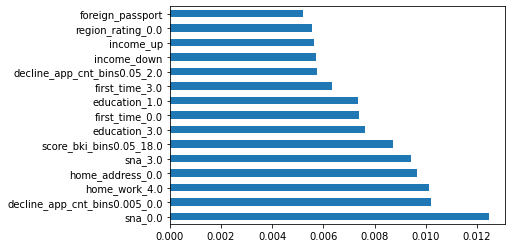

In [182]:
feature_select['importance'].head(15).plot(kind = 'barh')

In [183]:
logreg = LogisticRegression(class_weight = 'balanced', solver='liblinear', max_iter=1000)
metrics = check_metrics (data, cat_features + num_features + bin_features, test, 'default', MinMaxScaler(), logreg, metrics, 'feat_imp_2')
metrics

,baseline,new_features,feat_imp_1,feat_imp_2
f1,0.3410,0.3425,0.3431,0.3430
precision,0.2287,0.2296,0.2301,0.2300
recall,0.6698,0.6742,0.6745,0.6741
roc_auc,0.7351,0.7350,0.7357,0.7357


Метрики стали немного хуже, но я считаю, что наша модель стала более стабильной и менее склонной к переобучению после удаления скоррелированных признаков.

In [184]:
features = cat_features + num_features + bin_features

# Гиперпараметры модели: баланс

Мы знаем, что выборка нсбалансрованна по целевой переменной. Поэтому первым делом попробуем обучать модель с разным весом классов. Учтем, что среднее количество дефолтов на трейне = 0.12 - 0.13

In [185]:
for i in range(10, 26):
    p = i/100
    logreg = LogisticRegression(class_weight = {0.0: p, 1.0: 1 - p}, solver='liblinear', max_iter=1000)
    metrics = check_metrics (data, features, test, 'default', MinMaxScaler(), logreg, metrics, 'balance_p_'+ str(p))
metrics

,baseline,new_features,feat_imp_1,feat_imp_2,balance_p_0.1,balance_p_0.11,balance_p_0.12,balance_p_0.13,balance_p_0.14,balance_p_0.15,balance_p_0.16,balance_p_0.17,balance_p_0.18,balance_p_0.19,balance_p_0.2,balance_p_0.21,balance_p_0.22,balance_p_0.23,balance_p_0.24,balance_p_0.25
f1,0.3410,0.3425,0.3431,0.3430,0.3223,0.3304,0.3385,0.3453,0.3487,0.3518,0.3534,0.3550,0.3561,0.3553,0.3524,0.3467,0.3420,0.3362,0.3277,0.3226
precision,0.2287,0.2296,0.2301,0.2300,0.2036,0.2131,0.2234,0.2332,0.2414,0.2501,0.2584,0.2676,0.2769,0.2859,0.2941,0.3007,0.3084,0.3170,0.3228,0.3335
recall,0.6698,0.6742,0.6745,0.6741,0.7721,0.7353,0.6989,0.6650,0.6273,0.5927,0.5588,0.5272,0.4990,0.4693,0.4398,0.4094,0.3841,0.3582,0.3329,0.3125
roc_auc,0.7351,0.7350,0.7357,0.7357,0.7356,0.7356,0.7357,0.7357,0.7357,0.7357,0.7357,0.7357,0.7357,0.7357,0.7357,0.7357,0.7357,0.7357,0.7357,0.7357


Визуализируем изменение метрик по отношению к изменению баланса

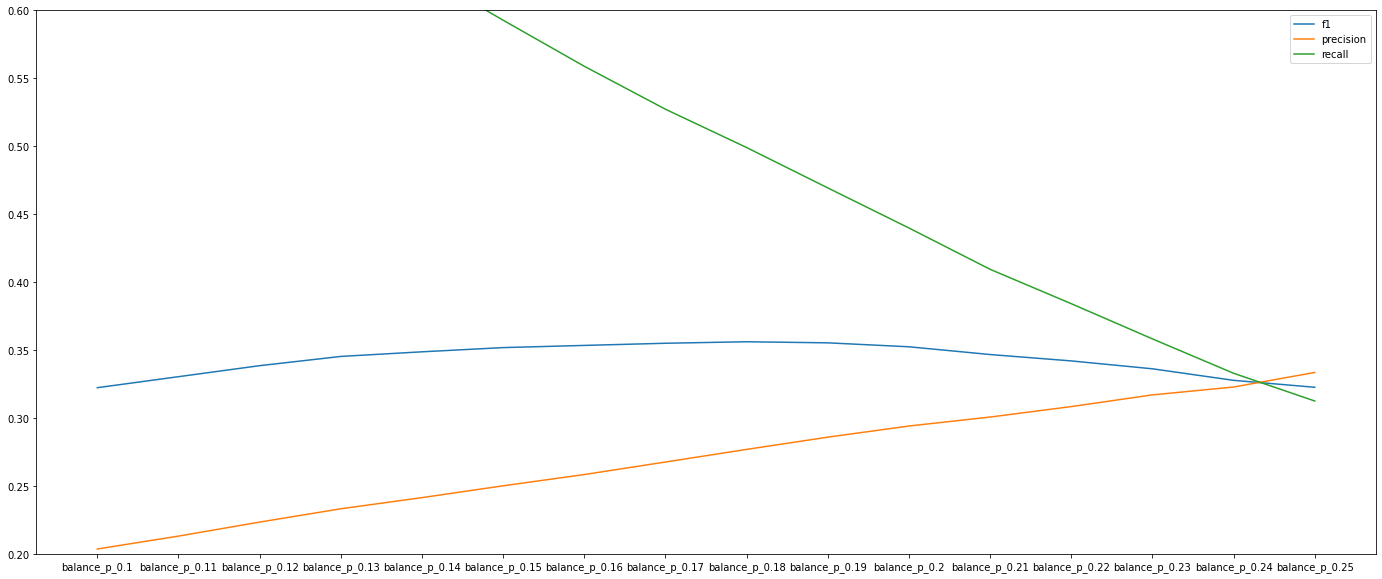

In [186]:
plt.figure(figsize=(24, 10))
x = metrics.columns[4:]
for i in ['f1', 'precision', 'recall']:
    plt.plot(x, metrics.loc[i, x])
   
plt.legend(['f1', 'precision', 'recall'])
plt.ylim([0.2, 0.6])
plt.show()

Посмотрим только на f1

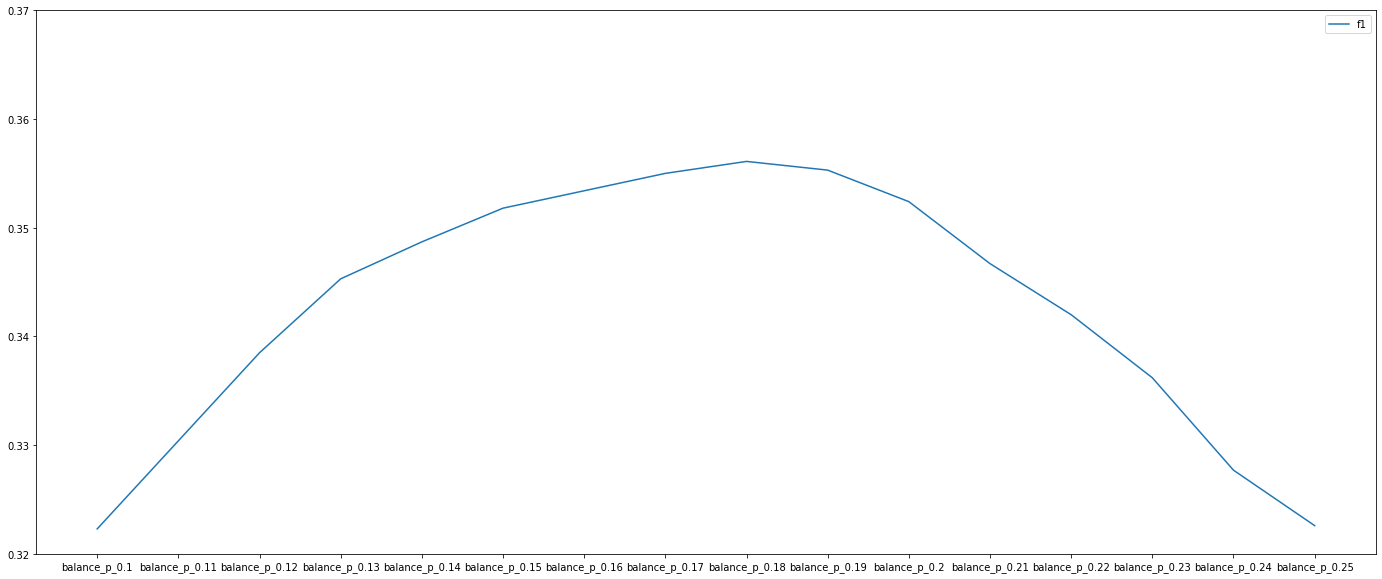

In [187]:
plt.figure(figsize=(24, 10))
x = metrics.columns[4:]
for i in ['f1']:
    plt.plot(x, metrics.loc[i, x])
   
plt.legend(['f1'])
plt.ylim([0.32, 0.37])
plt.show()

При class_weight = {0.0: 0.18, 1.0: 0.82} получилось добиться максимальной эффективности по метрике f1.

# Контроль переобучения

Проверим велика ли разница метрик на трейне и валидации.

[train] F1-score = 0.35976 +/- 0.00205
[valid] F1-score = 0.35615 +/- 0.00696


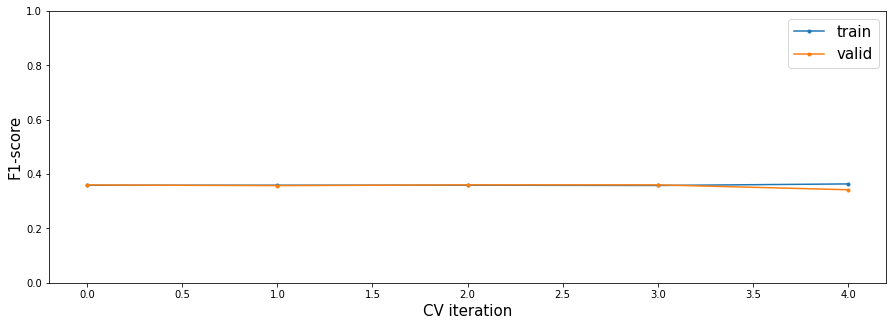

In [188]:
logreg = LogisticRegression(class_weight = {0.0: 0.18, 1.0: 0.82}, solver='liblinear', max_iter=1000)
X, y = X_y_train_split (data, features, test, 'default', MinMaxScaler())
cv_metrics = cross_validate(logreg, X, y, cv=5, scoring='f1', return_train_score= True)
plot_cv_metrics(cv_metrics)

Есть разница в несколько десятых процента, будем считать эту разницу приемлимой. По этой причине не вижу особой потребности в подборе коэффициента и типа регуляризации.

# Обучение модели. Сабмит решения

Разделим на тест и трейн, обучим модель.

In [189]:
logreg = LogisticRegression(class_weight = {0.0: 0.18, 1.0: 0.82}, solver='liblinear', max_iter=1000)
X, y = X_y_train_split (data, features, test, 'default', MinMaxScaler())
logreg.fit(X, y)

LogisticRegression(class_weight={0.0: 0.18, 1.0: 0.82}, max_iter=1000,
                   solver='liblinear')

Сделаем предикт на тест. Сохраним сабмит.

In [190]:
test_df = data[features].iloc[-test.shape[0]:, :]
predict_submission = logreg.predict(test_df)

In [191]:
sample_submission['default'] =  predict_submission.astype(bool)
sample_submission.to_csv('submission_final.csv', index=False)
sample_submission.head(5)

,client_id,default
0,74835,False
1,17527,True
2,75683,False
3,26883,False
4,28862,False


Результат на лидерборде f1 = 0.3575

# Заключительные выводы:

Самые значимые признаки:
1. Оценка банка
2. Связь заёмщика с клиентом банка
3. Количество отказанных прошлых заявок
4. Давность наличия информации о заёмщике
5. Адрес: домашний, рабочий и их комбинации.
6. Рейтинг региона
7. Образование 
8. Количество запросов в БКИ

Малозначимые признаки:
- Пол
- Возраст

Требующие дополнительного анализа:
- Доход

Возможные пути улучшения модели:
1. Провести дополнительный подбор гиперпараметров для логистической регрессии: solver, тип регуляризации, коээфициент регуляризации.
2. Обучить другие модели и использовать ансамблевые решения совместно с другими моделями: RandomForestClassifier, LightGBM и др.
3. Глубже погрузиться в анализ признаков, найти связи и сгенерировать новые признаки.
4. Обогатить информацию внешними данными.